In [26]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\91983\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [228]:
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

Fetching equity data...
✅ Equities saved to equities.csv | Shape: (2668, 3)

Fetching Treasury yield data...
✅ Yields saved to treasury_yields.csv | Shape: (2768, 2)

--- Starting Exploratory Data Analysis (EDA) ---


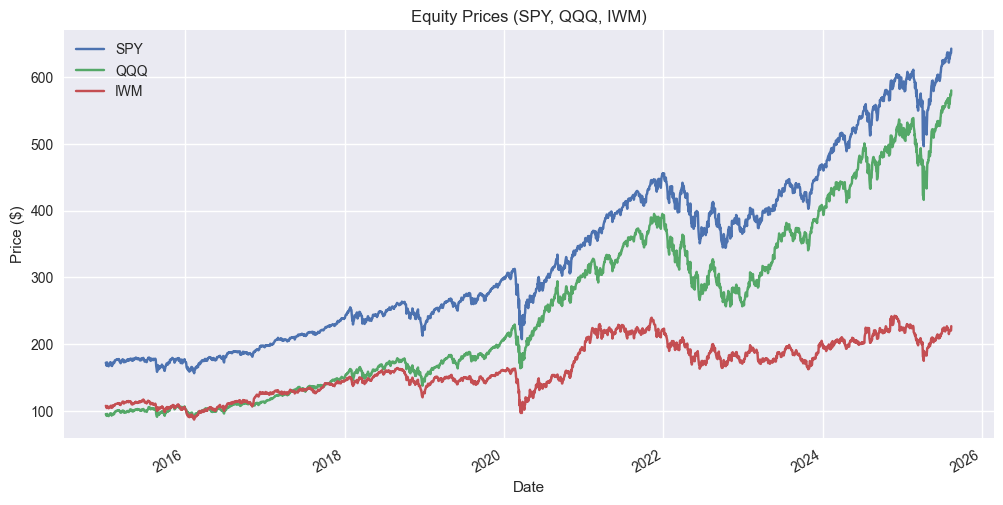


📌 Equity Return Correlations:


,SPY,QQQ,IWM
SPY,1.0000,0.9333,0.8688
QQQ,0.9333,1.0000,0.7705
IWM,0.8688,0.7705,1.0000


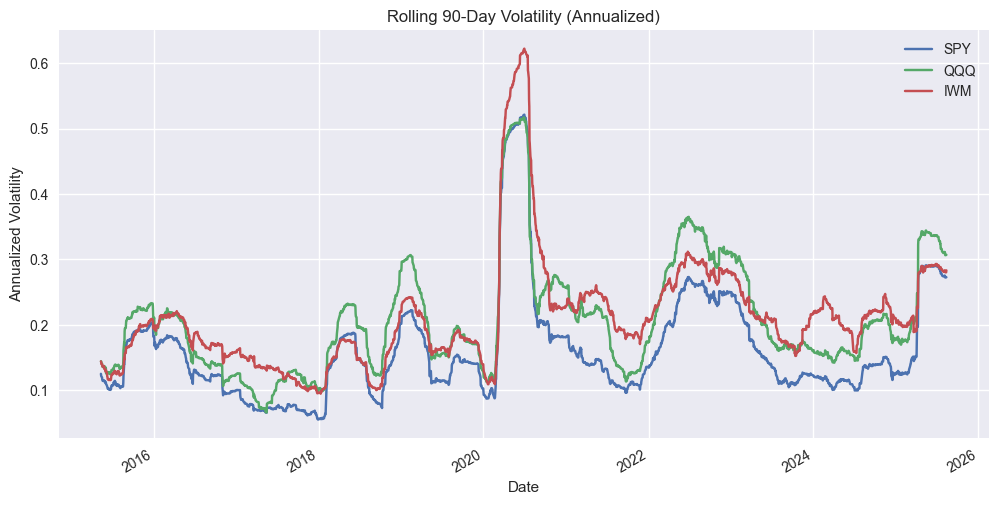

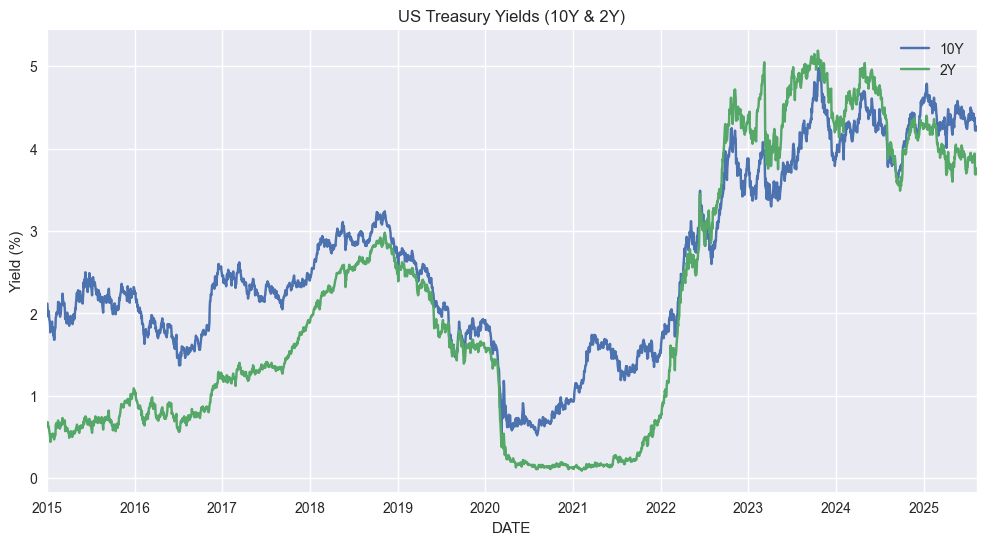

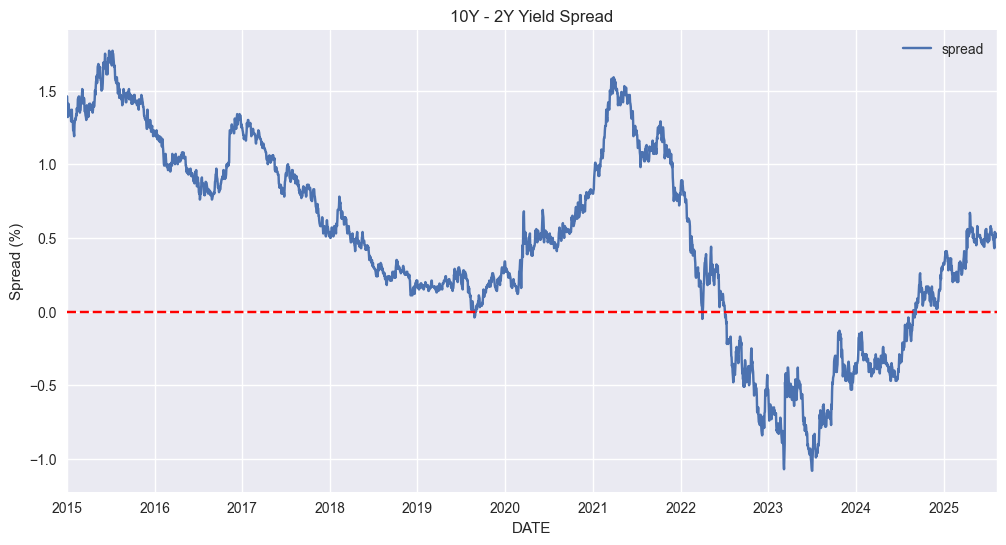

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import statsmodels.api as sm
from datetime import datetime
from IPython.display import display

# --- Initial Setup ---
plt.style.use("seaborn-v0_8")
pd.set_option("display.float_format", lambda x: f"{x:.4f}")


# =================================================================
# PART 1: DATA FETCHING & EDA
# =================================================================

def fetch_equities(tickers, start="2015-01-01", end=None):
    """
    Fetch equity prices from Stooq, save to CSV.
    Stooq returns reverse chronological order — we sort ascending.
    """
    if end is None:
        end = datetime.today().strftime('%Y-%m-%d')
    
    print("Fetching equity data...")
    # Using 'stooq' which is generally reliable.
    df = web.DataReader(tickers, "stooq", start, end)
    df = df.sort_index()
    adj_close = df["Close"] # Using Close as Stooq provides adjusted prices
    
    adj_close.to_csv("equities.csv")
    print(f"✅ Equities saved to equities.csv | Shape: {adj_close.shape}")
    return adj_close


def fetch_treasury_yields(start="2015-01-01", end=None):
    """
    Fetch 10-year and 2-year US Treasury yields from FRED, save to CSV.
    """
    if end is None:
        end = datetime.today().strftime('%Y-%m-%d')
    
    print("\nFetching Treasury yield data...")
    dgs10 = web.DataReader("DGS10", "fred", start, end)  # 10-year yield
    dgs2 = web.DataReader("DGS2", "fred", start, end)    # 2-year yield

    yields = pd.concat([dgs10, dgs2], axis=1)
    yields.columns = ["10Y", "2Y"]
    
    # Forward-fill missing values (e.g., holidays)
    yields = yields.ffill()

    yields.to_csv("treasury_yields.csv")
    print(f"✅ Yields saved to treasury_yields.csv | Shape: {yields.shape}")
    return yields


# --- Execute Data Fetching ---
tickers = ["SPY", "QQQ", "IWM"] 
eq = fetch_equities(tickers)
ty = fetch_treasury_yields()

# --- Load Data and Perform EDA ---
print("\n--- Starting Exploratory Data Analysis (EDA) ---")
eq = pd.read_csv("equities.csv", index_col=0, parse_dates=True)
yields = pd.read_csv("treasury_yields.csv", index_col=0, parse_dates=True)

eq_returns = eq.pct_change().dropna()

# 📈 1. Equity Price Plot
eq.plot(figsize=(12, 6), title="Equity Prices (SPY, QQQ, IWM)")
plt.ylabel("Price ($)")
plt.show()

# 🔗 2. Correlation Matrix
print("\n📌 Equity Return Correlations:")
display(eq_returns.corr())

# 🔄 3. Rolling Volatility (90-day)
(eq_returns.rolling(90).std() * np.sqrt(252)).plot(figsize=(12, 6),
                                                  title="Rolling 90-Day Volatility (Annualized)")
plt.ylabel("Annualized Volatility")
plt.show()

# 💹 4. Yield Spread Analysis
yields["spread"] = yields["10Y"] - yields["2Y"]

yields[["10Y", "2Y"]].plot(figsize=(12, 6), title="US Treasury Yields (10Y & 2Y)")
plt.ylabel("Yield (%)")
plt.show()

yields[["spread"]].plot(figsize=(12, 6), title="10Y - 2Y Yield Spread")
plt.axhline(0, color="red", linestyle="--")
plt.ylabel("Spread (%)")
plt.show()

✅ Risk-free rate saved | Shape: (2767, 1)

=== Static CAPM Results ===


C:\Users\91983\AppData\Local\Temp\ipykernel_33808\36248543.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf = rf.fillna(method="ffill") / 100  # Convert from % to decimal


,Beta,t-value,R²
Ticker,,,
SPY,1.0000,217405928131458656.0000,1.0000
QQQ,1.0363,232.1958,0.9529
IWM,1.0290,169.7687,0.9154



Fetching Fama–French 3-Factor Data...


C:\Users\91983\AppData\Local\Temp\ipykernel_33808\36248543.py:66: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench",



=== Static Fama–French 3F Results ===


,Beta_Mkt,t_Mkt,Beta_SMB,t_SMB,Beta_HML,t_HML,R²
Ticker,,,,,,,
SPY,0.9685,28.7982,-0.0428,-0.7126,0.0454,1.0569,0.2471
QQQ,1.0986,32.2385,-0.0468,-0.7678,-0.3731,-8.5703,0.3148
IWM,0.9950,29.5179,0.9375,15.5653,0.2756,6.4000,0.3462



✅ Betas saved: rolling_capm_betas.csv, rolling_ff3_betas.csv


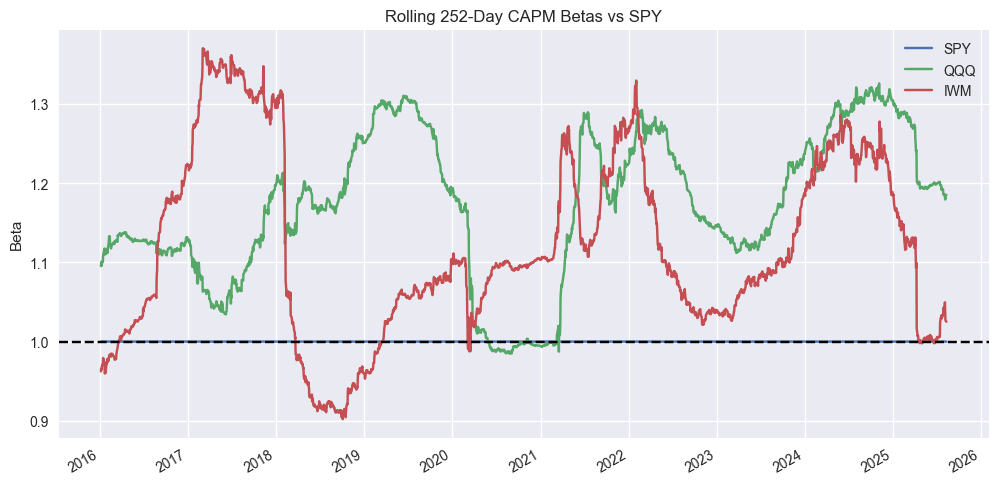

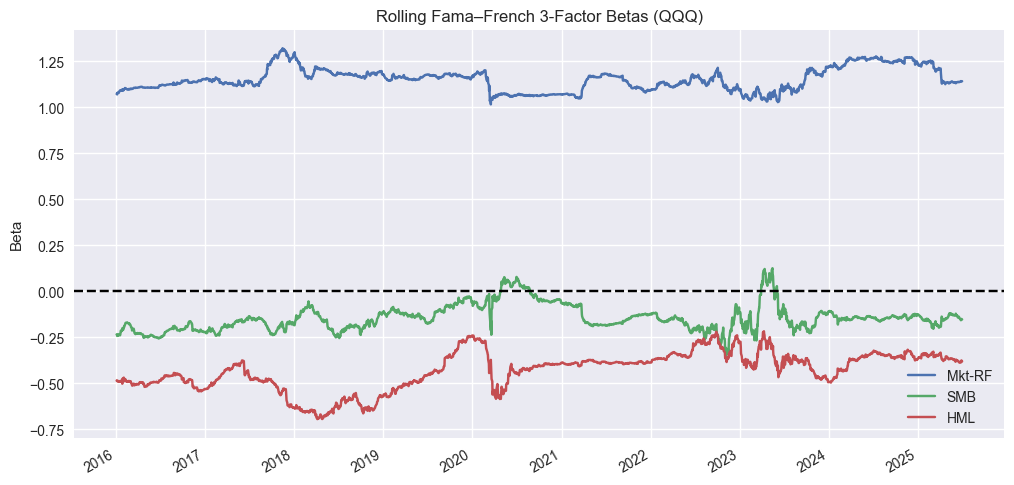

In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas_datareader.data as web

# ---------------------------
# 1. Fetch Risk-Free Rate
# ---------------------------
rf = web.DataReader("DGS3MO", "fred", eq.index.min(), eq.index.max())
rf = rf.fillna(method="ffill") / 100  # Convert from % to decimal

rf.to_csv("risk_free.csv")
print(f"✅ Risk-free rate saved | Shape: {rf.shape}")

# ---------------------------
# 2. Compute Excess Returns
# ---------------------------
excess_returns = eq_returns.sub(rf["DGS3MO"], axis=0)  # Asset excess returns
market_excess = excess_returns["SPY"]                  # SPY as market proxy
excess_returns.dropna(inplace=True)
market_excess.dropna(inplace=True)

# ---------------------------
# 3. Static CAPM Beta Function
# ---------------------------
def capm_beta(asset_excess, market_excess):
    X = sm.add_constant(market_excess)
    aligned_data = pd.concat([asset_excess, X], axis=1).dropna()
    model = sm.OLS(aligned_data.iloc[:, 0], aligned_data.iloc[:, 1:]).fit()
    return model.params["SPY"], model.tvalues["SPY"], model.rsquared, model.summary()

# CAPM for all tickers
capm_stats = []
for ticker in eq.columns:
    beta, tval, r2, summary = capm_beta(excess_returns[ticker], market_excess)
    capm_stats.append({
        "Ticker": ticker,
        "Beta": beta,
        "t-value": tval,
        "R²": r2
    })
capm_df = pd.DataFrame(capm_stats).set_index("Ticker")
print("\n=== Static CAPM Results ===")
display(capm_df)

# ---------------------------
# 4. Rolling CAPM Betas
# ---------------------------
window = 252
rolling_betas = pd.DataFrame(index=excess_returns.index, columns=eq.columns)

for ticker in eq.columns:
    for i in range(window, len(excess_returns)):
        y = excess_returns[ticker].iloc[i-window:i]
        X = sm.add_constant(market_excess.iloc[i-window:i])
        model = sm.OLS(y, X).fit()
        rolling_betas.at[excess_returns.index[i], ticker] = model.params["SPY"]

rolling_betas = rolling_betas.astype(float)
rolling_betas.to_csv("rolling_capm_betas.csv")

# ---------------------------
# 5. Fama–French 3-Factor Data
# ---------------------------
print("\nFetching Fama–French 3-Factor Data...")
ff3 = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench",
                     eq.index.min(), eq.index.max())[0]
ff3 = ff3 / 100  # Convert from % to decimal
ff3.index = pd.to_datetime(ff3.index)

# Align data
common_index = excess_returns.index.intersection(ff3.index)
excess_returns = excess_returns.loc[common_index]
ff3 = ff3.loc[common_index]
market_excess = ff3["Mkt-RF"]

# Fama–French regression
def fama_french_3f(asset_excess, ff_data):
    X = sm.add_constant(ff_data[["Mkt-RF", "SMB", "HML"]])
    aligned_data = pd.concat([asset_excess, X], axis=1).dropna()
    model = sm.OLS(aligned_data.iloc[:, 0], aligned_data.iloc[:, 1:]).fit()
    return model.params, model.tvalues, model.rsquared, model.summary()

# FF3 for all tickers
ff3_stats = []
for ticker in eq.columns:
    params_ff, tvals_ff, r2_ff, summary_ff = fama_french_3f(excess_returns[ticker], ff3)
    ff3_stats.append({
        "Ticker": ticker,
        "Beta_Mkt": params_ff["Mkt-RF"],
        "t_Mkt": tvals_ff["Mkt-RF"],
        "Beta_SMB": params_ff["SMB"],
        "t_SMB": tvals_ff["SMB"],
        "Beta_HML": params_ff["HML"],
        "t_HML": tvals_ff["HML"],
        "R²": r2_ff
    })
ff3_df = pd.DataFrame(ff3_stats).set_index("Ticker")
print("\n=== Static Fama–French 3F Results ===")
display(ff3_df)

# ---------------------------
# 6. Rolling FF3 Betas
# ---------------------------
rolling_ff3_betas = pd.DataFrame(
    index=excess_returns.index,
    columns=pd.MultiIndex.from_product([eq.columns, ["Mkt-RF", "SMB", "HML"]])
)

for ticker in eq.columns:
    for i in range(window, len(excess_returns)):
        y = excess_returns[ticker].iloc[i-window:i]
        X = sm.add_constant(ff3[["Mkt-RF", "SMB", "HML"]].iloc[i-window:i])
        model = sm.OLS(y, X).fit()
        for factor in ["Mkt-RF", "SMB", "HML"]:
            rolling_ff3_betas.loc[excess_returns.index[i], (ticker, factor)] = model.params[factor]

rolling_ff3_betas = rolling_ff3_betas.astype(float)
rolling_ff3_betas.to_csv("rolling_ff3_betas.csv")
print("\n✅ Betas saved: rolling_capm_betas.csv, rolling_ff3_betas.csv")

# ---------------------------
# 7. Plot examples
# ---------------------------
rolling_betas.plot(figsize=(12, 6), title="Rolling 252-Day CAPM Betas vs SPY")
plt.axhline(1, color="black", linestyle="--")
plt.ylabel("Beta")
plt.show()

rolling_ff3_betas["QQQ"].plot(figsize=(12, 6), title="Rolling Fama–French 3-Factor Betas (QQQ)")
plt.axhline(0, color="black", linestyle="--")
plt.ylabel("Beta")
plt.show()


--- Definitive Bond Analysis & Portfolio Module with Live Data ---
Fetching live U.S. Treasury yield curve data from FRED...
✅ Data fetched for date: 2025-08-12
✅ Nelson–Siegel curve fitted to live market data.

Fitted Nelson–Siegel Params (β0, β1, β2, τ): [ 0.0526 -0.0077 -0.0406  2.0043]
[0.97944764 0.96149424 0.94481029 0.92857909 0.91232506 0.89579819
 0.87889494 0.86160371 0.84396753 0.82605882 0.80796268 0.78976636
 0.77155275 0.75339691 0.7353644  0.71751087]
[ 19.58895284  19.22988479  18.89620575  18.57158182  18.24650123
  17.91596386  17.57789872  17.23207412  16.87935063  16.52117634
  16.1592537   15.79532717  15.43105499  15.06793824  14.70728808
 731.86108784]
[0.97944764 0.96149424 0.94481029 0.92857909 0.91232506 0.89579819
 0.87889494 0.86160371 0.84396753 0.82605882]
[ 24.48619105  24.03735598  23.62025718  23.21447727  22.80812654
  22.39495482  21.97237341  21.54009265  21.09918828 846.71028735]
[0.97944764 0.96149424 0.94481029 0.92857909 0.91232506 0.89579819
 0.

C:\Users\91983\AppData\Local\Temp\ipykernel_33808\3579493906.py:50: RuntimeWarning: invalid value encountered in divide
  term1 = (1 - np.exp(-t_tau)) / t_tau


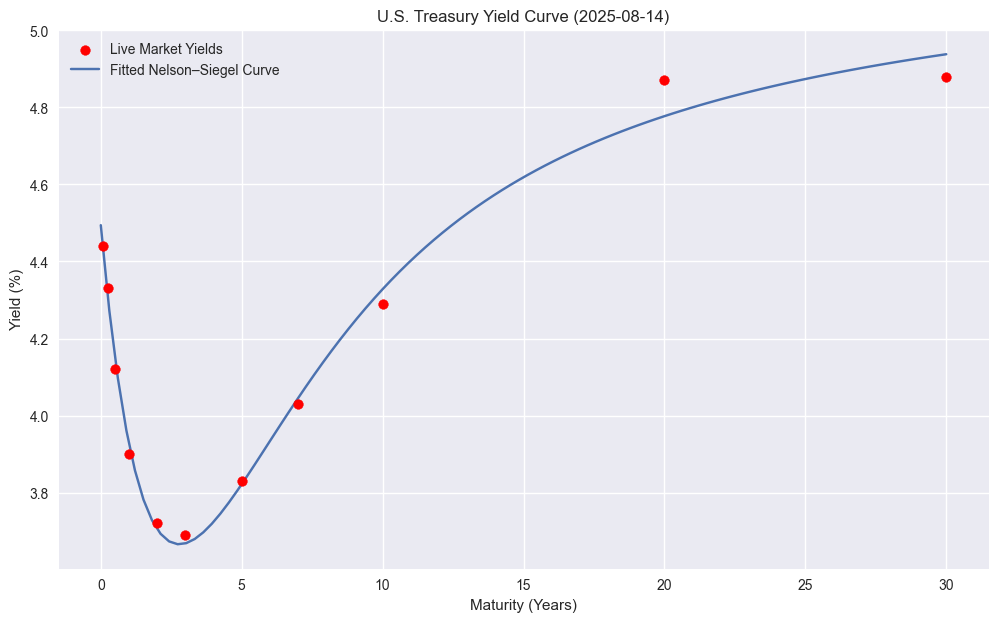

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
import pandas_datareader.data as web
from datetime import datetime, timedelta

# --- Setup ---
plt.style.use("seaborn-v0_8")
pd.set_option("display.float_format", lambda x: f"{x:.4f}")

print("--- Definitive Bond Analysis & Portfolio Module with Live Data ---")

# =================================================================
# Part 1: Live Data Fetching
# =================================================================
def fetch_live_yield_curve():
    """
    Fetches the latest available daily U.S. Treasury par yield curve rates from FRED.
    """
    print("Fetching live U.S. Treasury yield curve data from FRED...")
    
    yield_tickers = {
        'DGS1MO': 1/12, 'DGS3MO': 3/12, 'DGS6MO': 6/12,
        'DGS1': 1, 'DGS2': 2, 'DGS3': 3, 'DGS5': 5,
        'DGS7': 7, 'DGS10': 10, 'DGS20': 20, 'DGS30': 30
    }
    
    end_date = datetime.today()
    start_date = end_date - timedelta(days=30)
    
    yield_data = web.DataReader(list(yield_tickers.keys()), 'fred', start_date, end_date)
    
    latest_yields = yield_data.iloc[-1].dropna()
    latest_date = latest_yields.name.strftime('%Y-%m-%d')
    print(f"✅ Data fetched for date: {latest_date}")

    maturities = np.array([yield_tickers[ticker] for ticker in latest_yields.index])
    market_rates = latest_yields.values / 100

    return maturities, market_rates

# =================================================================
# Part 2: Nelson–Siegel Model
# =================================================================
def nelson_siegel(params, maturities):
    beta0, beta1, beta2, tau = params
    t_tau = maturities / tau
    term1 = (1 - np.exp(-t_tau)) / t_tau
    term2 = term1 - np.exp(-t_tau)
    term1[maturities == 0] = 1
    term2[maturities == 0] = 0
    return beta0 + beta1 * term1 + beta2 * term2

def fit_nelson_siegel_to_market(market_maturities, market_yields):
    def objective_function(params, maturities, yields):
        return np.sum((nelson_siegel(params, maturities) - yields) ** 2)

    initial_params = [market_yields[-1], market_yields[0] - market_yields[-1], 0, 1.0]
    bounds = [(0, 1), (-1, 1), (-1, 1), (0.01, 10)]
    result = minimize(objective_function, initial_params, args=(market_maturities, market_yields), bounds=bounds)
    optimal_params = result.x
    fitted_curve_func = lambda t: nelson_siegel(optimal_params, t)
    print("✅ Nelson–Siegel curve fitted to live market data.")
    return optimal_params, fitted_curve_func

# =================================================================
# Part 3: Bond Class
# =================================================================
class Bond:
    def __init__(self, face_value, coupon_rate, years_to_maturity, freq=2):
        self.face_value = face_value
        self.coupon_rate = coupon_rate
        self.years_to_maturity = years_to_maturity
        self.freq = freq
        self.coupon_payment = (face_value * coupon_rate) / freq
        self.n_coupons = int(years_to_maturity * freq)
        self.cf_maturities = np.arange(1, self.n_coupons + 1) / freq
        self.cash_flows = np.full(self.n_coupons, self.coupon_payment)
        self.cash_flows[-1] += self.face_value

    def price1(self, yield_curve_func):
        spot_rates = yield_curve_func(self.cf_maturities)
        pv_factors = np.exp(-spot_rates * self.cf_maturities)
        print(pv_factors)
        print(self.cash_flows * pv_factors)
        return np.sum(self.cash_flows * pv_factors)

    def get_risk_measures(self, yield_curve_func, basis_point_shift=0.0001):
        price_base = self.price1(yield_curve_func)
        curve_up_func = lambda t: yield_curve_func(t) + basis_point_shift
        price_up = self.price1(curve_up_func)
        curve_down_func = lambda t: yield_curve_func(t) - basis_point_shift
        price_down = self.price1(curve_down_func)

        modified_duration = (price_down - price_up) / (2 * price_base * basis_point_shift)
        convexity = (price_up + price_down - 2 * price_base) / (price_base * (basis_point_shift ** 2))
        
        return {'modified_duration': modified_duration, 'convexity': convexity}

# =================================================================
# Part 4: Bond Portfolio Class
# =================================================================
class BondPortfolio:
    def __init__(self, bonds, weights):
        if len(bonds) != len(weights):
            raise ValueError("Number of bonds and weights must match.")
        self.bonds = bonds
        self.weights = np.array(weights) / np.sum(weights)  # normalize

    def price(self, yield_curve_func):
        prices = np.array([bond.price1(yield_curve_func) for bond in self.bonds])
        return np.dot(prices, self.weights)

    def risk_measures(self, yield_curve_func):
        risks = [bond.get_risk_measures(yield_curve_func) for bond in self.bonds]
        durations = np.array([r['modified_duration'] for r in risks])
        convexities = np.array([r['convexity'] for r in risks])
        portfolio_duration = np.dot(durations, self.weights)
        portfolio_convexity = np.dot(convexities, self.weights)
        return {'portfolio_duration': portfolio_duration, 'portfolio_convexity': portfolio_convexity}

# =================================================================
# Main Execution
# =================================================================
if __name__ == "__main__":
    try:
        market_maturities, market_yields = fetch_live_yield_curve()
        params, fitted_curve = fit_nelson_siegel_to_market(market_maturities, market_yields)
        print(f"\nFitted Nelson–Siegel Params (β0, β1, β2, τ): {np.round(params, 4)}")

        # --- Example Bonds ---
        bond1 = Bond(1000, 0.04, 8)
        bond2 = Bond(1000, 0.05, 5)
        bond3 = Bond(1000, 0.03, 10)

        # --- Bond Portfolio ---
        portfolio = BondPortfolio([bond1, bond2, bond3], weights=[0.5, 0.3, 0.2])

        # Portfolio Price & Risk
        portfolio_price = portfolio.price(fitted_curve)
        portfolio_risk = portfolio.risk_measures(fitted_curve)

        print(f"\nPortfolio Price: ${portfolio_price:.2f}")
        print(f"Portfolio Duration: {portfolio_risk['portfolio_duration']:.2f}")
        print(f"Portfolio Convexity: {portfolio_risk['portfolio_convexity']:.2f}")

        # --- Visualize Yield Curve ---
        plt.figure(figsize=(12, 7))
        plt.scatter(market_maturities, market_yields * 100, color='red', zorder=5, label='Live Market Yields')
        plot_maturities = np.linspace(0, 30, 100)
        plot_yields = fitted_curve(plot_maturities) * 100
        plt.plot(plot_maturities, plot_yields, label='Fitted Nelson–Siegel Curve')
        plt.title(f'U.S. Treasury Yield Curve ({datetime.today().strftime("%Y-%m-%d")})')
        plt.xlabel('Maturity (Years)')
        plt.ylabel('Yield (%)')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print("\n❌ An error occurred. This might be due to data fetching issues from FRED.")
        print(f"Error details: {e}")


In [232]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

print("--- Starting Options Module ---")

# =================================================================
# Part 1: Black-Scholes-Merton Model
# =================================================================
def black_scholes_merton(S, K, T, r, sigma, option_type='call'):
    """Prices a European call or put option using Black-Scholes-Merton."""
    if T <= 0:
        return max(0, S - K) if option_type == 'call' else max(0, K - S)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type.lower() == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")

# =================================================================
# Part 2: Greeks
# =================================================================
def calculate_greeks(S, K, T, r, sigma, option_type='call'):
    """Calculates option Greeks: Delta, Gamma, Vega, Theta, Rho."""
    if T <= 0:
        return {g: 0.0 for g in ['delta', 'gamma', 'vega', 'theta', 'rho']}
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    pdf_d1 = norm.pdf(d1)
    
    gamma = pdf_d1 / (S * sigma * np.sqrt(T))
    vega = S * pdf_d1 * np.sqrt(T) / 100
    
    if option_type.lower() == 'call':
        delta = norm.cdf(d1)
        theta = (- (S * pdf_d1 * sigma) / (2 * np.sqrt(T)) 
                 - r * K * np.exp(-r * T) * norm.cdf(d2)) / 365
        rho = K * T * np.exp(-r * T) * norm.cdf(d2) / 100
    else:
        delta = norm.cdf(d1) - 1
        theta = (- (S * pdf_d1 * sigma) / (2 * np.sqrt(T)) 
                 + r * K * np.exp(-r * T) * norm.cdf(-d2)) / 365
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2) / 100

    return {'delta': delta, 'gamma': gamma, 'vega': vega, 'theta': theta, 'rho': rho}

# =================================================================
# Part 3: Binomial Tree Pricer
# =================================================================
def binomial_tree_pricer(S, K, T, r, sigma, n_steps=100, option_type='call', american=False):
    """Binomial tree option pricer (supports American)."""
    dt = T / n_steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    ST = np.array([S * (u ** (n_steps - i)) * (d ** i) for i in range(n_steps + 1)])
    if option_type.lower() == 'call':
        option_values = np.maximum(ST - K, 0)
    else:
        option_values = np.maximum(K - ST, 0)

    for i in range(n_steps - 1, -1, -1):
        for j in range(i + 1):
            hold = np.exp(-r * dt) * (p * option_values[j] + (1 - p) * option_values[j + 1])
            if american:
                exercise = (S * (u ** (i - j)) * (d ** j) - K) if option_type == 'call' else (K - S * (u ** (i - j)) * (d ** j))
                option_values[j] = max(hold, exercise)
            else:
                option_values[j] = hold
    return option_values[0]

# =================================================================
# Part 4: Implied Volatility
# =================================================================
def implied_volatility(market_price, S, K, T, r, option_type='call'):
    """Implied volatility using Brentq root-finding."""
    def objective_function(sigma):
        return black_scholes_merton(S, K, T, r, sigma, option_type) - market_price

    try:
        return brentq(objective_function, 1e-6, 5.0)
    except ValueError:
        return np.nan

# =================================================================
# Example Run
# =================================================================
if __name__ == "__main__":
    S0, K0, T0, r0, sigma0 = 100, 105, 1.0, 0.05, 0.2
    print(f"\nUnderlying: ${S0}, Strike: ${K0}, T: {T0}yr, r: {r0:.0%}, Vol: {sigma0:.0%}")

    # Black-Scholes
    bsm_price = black_scholes_merton(S0, K0, T0, r0, sigma0, 'call')
    print(f"BSM Price: ${bsm_price:.4f}")

    # Greeks
    greeks = calculate_greeks(S0, K0, T0, r0, sigma0, 'call')
    print("\nGreeks:")
    for k, v in greeks.items():
        print(f"  {k.capitalize():<6} : {v:.4f}")

    # Binomial Tree
    bin_price = binomial_tree_pricer(S0, K0, T0, r0, sigma0, n_steps=200, option_type='call', american=False)
    print(f"\nBinomial Tree Price: ${bin_price:.4f}")

    # Implied Vol
    iv = implied_volatility(bsm_price, S0, K0, T0, r0, 'call')
    print(f"Implied Volatility: {iv:.2%}")

--- Starting Options Module ---

Underlying: $100, Strike: $105, T: 1.0yr, r: 5%, Vol: 20%
BSM Price: $8.0214

Greeks:
  Delta  : 0.5422
  Gamma  : 0.0198
  Vega   : 0.3967
  Theta  : -0.0172
  Rho    : 0.4620

Binomial Tree Price: $8.0260
Implied Volatility: 20.00%


In [233]:
pip install cvxpy scipy pyportfolioopt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\91983\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\91983\AppData\Local\Temp\ipykernel_33808\215555416.py:37: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  assets_returns = assets.pct_change().dropna()
C:\Users\91983\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scs\__init__.py:96: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(
C:\Users\91983\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scs\__init__.py:126: UserWarning: Converting P to a CSC (compressed sparse column) matrix; may take a while.
  warn(



PORTFOLIO WEIGHTS (CONSTRAINED):


,Min Variance,Max Sharpe,Min CVaR (Target 7%)
QQQ,0.0500,0.1250,0.0696
SMH,0.0500,0.2750,0.0630
QUAL,0.1250,0.1250,0.1250
SPY,0.1250,0.1250,0.1250
TLT,0.1250,0.0500,0.1250
IEF,0.2750,0.0500,0.1797
PFF,0.1250,0.1250,0.0924
TIP,0.1250,0.1250,0.2203



PORTFOLIO PERFORMANCE METRICS (CONSTRAINED):


,Return,Volatility,Sharpe Ratio
Min Variance,0.0621,0.0868,0.4854
Max Sharpe,0.1400,0.1610,0.7455
Min CVaR (Target 7%),0.0700,0.0910,0.5493


C:\Users\91983\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scs\__init__.py:96: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(
C:\Users\91983\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scs\__init__.py:126: UserWarning: Converting P to a CSC (compressed sparse column) matrix; may take a while.
  warn(
C:\Users\91983\AppData\Local\Temp\ipykernel_33808\215555416.py:203: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (asset_vols[i], asset_rets[i]), xytext=(5, 5), textcoords='offset points')


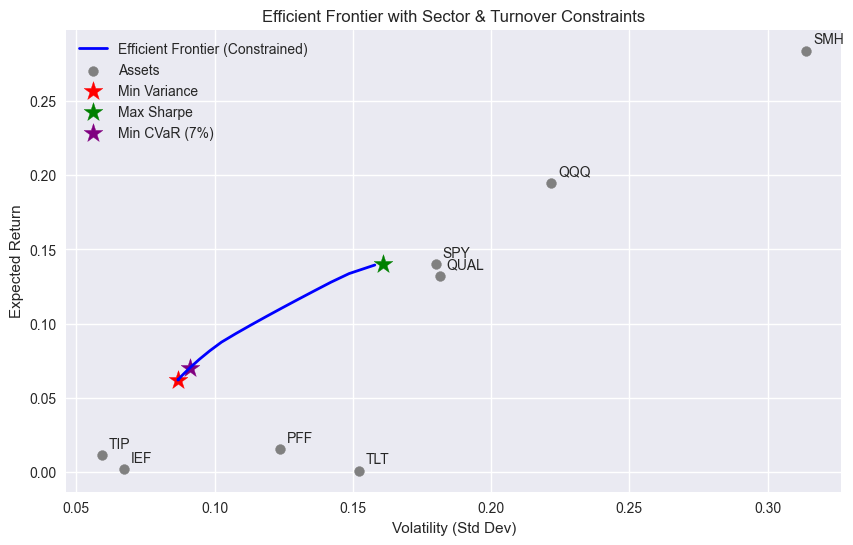

In [234]:
# =================================================================
# Cell 1: Imports
# =================================================================
import os
import pandas as pd
import numpy as np
import cvxpy as cp
from pandas_datareader import data as web
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display

# --- Setup ---
plt.style.use("seaborn-v0_8")
pd.set_option("display.float_format", lambda x: f"{x:.4f}")

# =================================================================
# Cell 2: Load Data
# =================================================================
tickers = [
    # Stocks
    "QQQ", "SMH", "QUAL", "SPY",
    # Bonds
    "TLT", "IEF", "PFF", "TIP"
]
data_file = "data/index_portfolio_test_Test11.csv"

if os.path.exists(data_file):
    assets = pd.read_csv(data_file, index_col=0, parse_dates=True).sort_index()
else:
    print("Fetching data for index portfolio...")
    df = web.DataReader(tickers, "stooq", start="2015-01-01", end=datetime.today().strftime("%Y-%m-%d"))
    assets = df["Close"].sort_index()
    os.makedirs("data", exist_ok=True)
    assets.to_csv(data_file)

assets_returns = assets.pct_change().dropna()

# =================================================================
# Cell 3: Constraints Setup (Sector + Turnover)
# =================================================================
# Example: sector caps
sector_map = {
    "Tech": ["QQQ", "SMH", "QUAL", "SPY"],  # treat as "equities" sector for example
    "Bonds": ["TLT", "IEF", "PFF", "TIP"]
}
sector_caps = {
    "Tech": 0.70,  # max 70% in Tech
    "Bonds": 0.80  # max 80% in Bonds
}

# Example: turnover constraint (previous weights)
prev_weights = pd.Series([0.125] * len(tickers), index=tickers)  # equally weighted previous portfolio
max_turnover = 0.30  # max sum of absolute changes in weights

# =================================================================
# Cell 4: Helper + CONSTRAINED Optimizer Functions
# =================================================================
def get_portfolio_metrics(weights, mu, Sigma, rf):
    if isinstance(weights, pd.Series):
        weights = weights.values
    ret = np.sum(mu.values * weights)
    vol = np.sqrt(np.dot(weights.T, np.dot(Sigma.values, weights)))
    sharpe = (ret - rf) / vol if vol != 0 else 0
    return ret, vol, sharpe

def apply_constraints(constraints_dict, asset_list):
    """Lower and upper bound vectors."""
    n = len(asset_list)
    lb, ub = np.zeros(n), np.ones(n)
    for ticker, bounds in constraints_dict.items():
        if ticker in asset_list:
            idx = asset_list.index(ticker)
            lb[idx], ub[idx] = bounds[0], bounds[1]
    return lb, ub

def add_sector_constraints(w, asset_list, constraints_list):
    """Returns a list of CVXPY constraints for sector caps."""
    sec_constraints = []
    for sector, tickers_in_sector in constraints_list.items():
        idxs = [asset_list.index(tk) for tk in tickers_in_sector if tk in asset_list]
        if idxs:
            sec_constraints.append(cp.sum(w[idxs]) <= sector_caps[sector])
    return sec_constraints

def add_turnover_constraint(w, prev_w, limit):
    """Returns turnover constraint."""
    return [cp.norm(w - prev_w.values, 1) <= limit]

def min_variance_optimizer(Sigma, constraints, asset_list):
    n = Sigma.shape[0]
    w = cp.Variable(n)
    lb, ub = apply_constraints(constraints, asset_list)
    all_constraints = [cp.sum(w) == 1, w >= lb, w <= ub]
    all_constraints += add_sector_constraints(w, asset_list, sector_map)
    all_constraints += add_turnover_constraint(w, prev_weights, max_turnover)
    risk = cp.quad_form(w, Sigma.values)
    prob = cp.Problem(cp.Minimize(risk), all_constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    return pd.Series(w.value, index=asset_list) if prob.status == 'optimal' else pd.Series(np.zeros(n), index=asset_list)

def max_sharpe_optimizer(mu, Sigma, constraints, asset_list):
    n = len(mu)
    w = cp.Variable(n)
    lb, ub = apply_constraints(constraints, asset_list)
    gamma = cp.Parameter(nonneg=True, value=0.1)
    ret = mu.values @ w
    risk = cp.quad_form(w, Sigma.values)
    all_constraints = [cp.sum(w) == 1, w >= lb, w <= ub]
    all_constraints += add_sector_constraints(w, asset_list, sector_map)
    all_constraints += add_turnover_constraint(w, prev_weights, max_turnover)
    prob = cp.Problem(cp.Maximize(ret - gamma * risk), all_constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    return pd.Series(w.value, index=asset_list) if prob.status == 'optimal' else pd.Series(np.zeros(n), index=asset_list)

def cvar_minimize_optimizer(returns_df, constraints, target_annual_return=0.08, alpha=0.95):
    R = returns_df.values
    T, n = R.shape
    w = cp.Variable(n)
    lb, ub = apply_constraints(constraints, returns_df.columns.tolist())
    z = cp.Variable(T)
    v = cp.Variable()
    loss = -R @ w
    all_constraints = [
        z >= 0, z >= loss - v, cp.sum(w) == 1,
        returns_df.mean(axis=0).values @ w * 252 >= target_annual_return,
        w >= lb, w <= ub
    ]
    all_constraints += add_sector_constraints(w, returns_df.columns.tolist(), sector_map)
    all_constraints += add_turnover_constraint(w, prev_weights, max_turnover)
    prob = cp.Problem(cp.Minimize(v + (1/(1-alpha)) * cp.sum(z) / T), all_constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    return pd.Series(w.value, index=returns_df.columns) if prob.status == 'optimal' else pd.Series(np.zeros(n), index=returns_df.columns)

# =================================================================
# Cell 5: Run
# =================================================================
if __name__ == "__main__":
    rets = assets_returns.copy()
    mu = rets.mean() * 252
    Sigma = rets.cov() * 252
    rf_annual = 0.02

    constraints = {tk: (0.05, 1) for tk in tickers}

    w_mv = min_variance_optimizer(Sigma, constraints, mu.index.tolist())
    w_ms = max_sharpe_optimizer(mu, Sigma, constraints, mu.index.tolist())
    w_cvar = cvar_minimize_optimizer(rets, constraints, target_annual_return=0.07)

    all_portfolios = pd.DataFrame({'Min Variance': w_mv, 'Max Sharpe': w_ms, 'Min CVaR (Target 7%)': w_cvar})
    print("\nPORTFOLIO WEIGHTS (CONSTRAINED):")
    display(all_portfolios.round(4))

    # --- Metrics ---
    ret_mv, vol_mv, sharpe_mv = get_portfolio_metrics(w_mv, mu, Sigma, rf_annual)
    ret_ms, vol_ms, sharpe_ms = get_portfolio_metrics(w_ms, mu, Sigma, rf_annual)
    ret_cvar, vol_cvar, sharpe_cvar = get_portfolio_metrics(w_cvar, mu, Sigma, rf_annual)
    summary_df = pd.DataFrame({
        'Min Variance': {'Return': ret_mv, 'Volatility': vol_mv, 'Sharpe Ratio': sharpe_mv},
        'Max Sharpe': {'Return': ret_ms, 'Volatility': vol_ms, 'Sharpe Ratio': sharpe_ms},
        'Min CVaR (Target 7%)': {'Return': ret_cvar, 'Volatility': vol_cvar, 'Sharpe Ratio': sharpe_cvar},
    }).T
    print("\nPORTFOLIO PERFORMANCE METRICS (CONSTRAINED):")
    display(summary_df.round(4))

        # --- Efficient Frontier with Constraints ---
    frontier_returns = []
    frontier_vols = []
    frontier_weights = []

    target_returns = np.linspace(mu.min(), mu.max(), 50)

    for target in target_returns:
        w = cp.Variable(len(mu))
        lb, ub = apply_constraints(constraints, mu.index.tolist())
        all_constraints = [
            cp.sum(w) == 1,
            mu.values @ w >= target,
            w >= lb, w <= ub
        ]
        all_constraints += add_sector_constraints(w, mu.index.tolist(), sector_map)
        all_constraints += add_turnover_constraint(w, prev_weights, max_turnover)

        risk = cp.quad_form(w, Sigma.values)
        prob = cp.Problem(cp.Minimize(risk), all_constraints)
        prob.solve(solver=cp.SCS, verbose=False)

        if prob.status == 'optimal':
            ret, vol, _ = get_portfolio_metrics(pd.Series(w.value, index=mu.index), mu, Sigma, rf_annual)
            frontier_returns.append(ret)
            frontier_vols.append(vol)
            frontier_weights.append(w.value)

    # --- Plot Efficient Frontier ---
    plt.figure(figsize=(10, 6))
    plt.plot(frontier_vols, frontier_returns, 'b-', label='Efficient Frontier (Constrained)', linewidth=2)

    # Plot assets
    asset_vols = np.sqrt(np.diag(Sigma))
    asset_rets = mu
    plt.scatter(asset_vols, asset_rets, c='grey', marker='o', s=50, label='Assets')
    for i, txt in enumerate(mu.index):
        plt.annotate(txt, (asset_vols[i], asset_rets[i]), xytext=(5, 5), textcoords='offset points')

    # Highlight portfolios
    plt.scatter(vol_mv, ret_mv, marker='*', s=200, color='red', label='Min Variance')
    plt.scatter(vol_ms, ret_ms, marker='*', s=200, color='green', label='Max Sharpe')
    plt.scatter(vol_cvar, ret_cvar, marker='*', s=200, color='purple', label='Min CVaR (7%)')

    plt.title("Efficient Frontier with Sector & Turnover Constraints")
    plt.xlabel("Volatility (Std Dev)")
    plt.ylabel("Expected Return")
    plt.legend()
    plt.grid(True)
    plt.show()

Using w_ms from session.


C:\Users\91983\AppData\Local\Temp\ipykernel_33808\1613500128.py:134: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()
C:\Users\91983\AppData\Local\Temp\ipykernel_33808\1613500128.py:135: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy_vol = (returns[hedge_underlying].rolling(vol_window).std() * np.sqrt(252)).fillna(method='bfill')


Final MTM value: -1.4516006423879024e+42
Total trade costs: 1.3189848569031208e+42


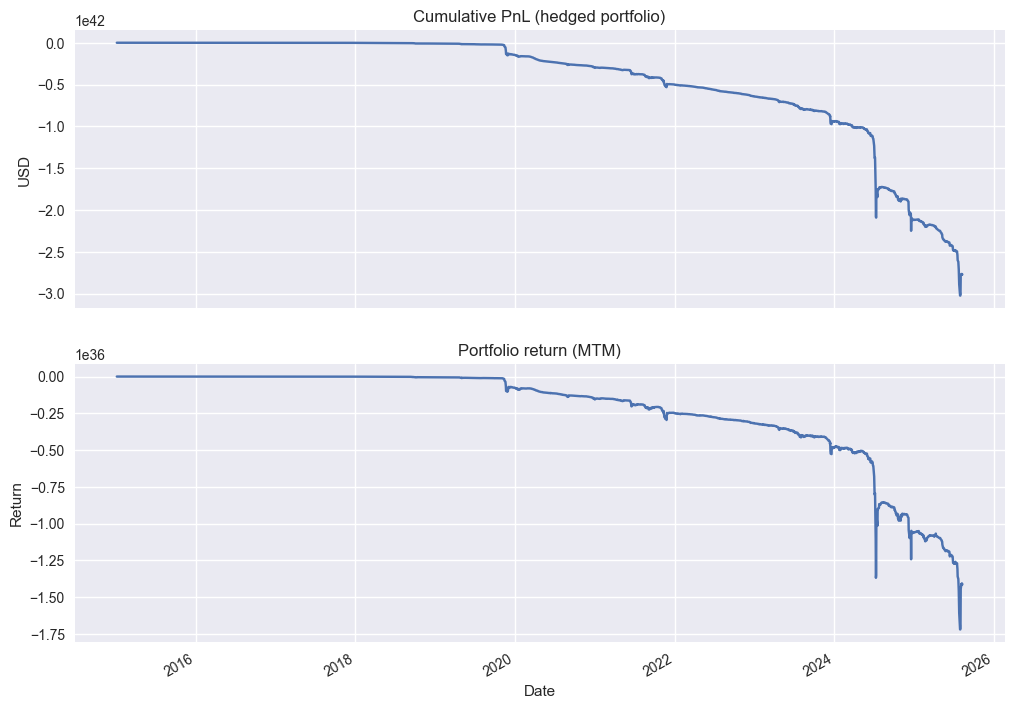

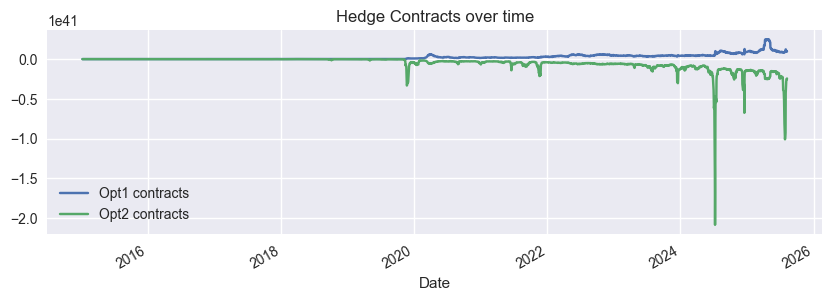

Saved data/phase4_hedge_results.csv and data/phase4_trade_log.csv


In [ ]:
# # -----------------------------
# # Phase 4: Hedging & Simulation (Full runnable cell)
# # Paste after your Phase 3 notebook (assets, assets_returns, tickers, w_ms, etc.)
# # -----------------------------
# import os
# import math
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from datetime import timedelta
# from scipy.stats import norm
# from scipy.optimize import brentq
# import statsmodels.api as sm

# plt.style.use("seaborn-v0_8")
# pd.set_option("display.float_format", lambda x: f"{x:.4f}")

# # -----------------------------
# # 0) Local BSM and Greeks (safe fallback if you already have them)
# # -----------------------------
# def black_scholes_merton(S, K, T, r, sigma, option_type='call'):
#     if T <= 0:
#         return max(0.0, S - K) if option_type == 'call' else max(0.0, K - S)
#     d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
#     d2 = d1 - sigma * np.sqrt(T)
#     if option_type == 'call':
#         return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
#     else:
#         return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# def calculate_greeks(S, K, T, r, sigma, option_type='call'):
#     if T <= 0:
#         if option_type == 'call':
#             delta = 1.0 if S > K else 0.0
#         else:
#             delta = -1.0 if S < K else 0.0
#         return {'delta': delta, 'gamma': 0.0, 'vega': 0.0, 'theta': 0.0, 'rho': 0.0}
#     d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
#     d2 = d1 - sigma * np.sqrt(T)
#     pdf = norm.pdf(d1)
#     delta = norm.cdf(d1) if option_type == 'call' else (norm.cdf(d1)-1)
#     gamma = pdf / (S * sigma * np.sqrt(T))
#     vega = S * pdf * np.sqrt(T) / 100.0
#     theta = None
#     rho = None
#     return {'delta': delta, 'gamma': gamma, 'vega': vega, 'theta': theta, 'rho': rho}

# # -----------------------------
# # 1) Delta+Gamma solver (two-option linear solve) - re-used from earlier
# # -----------------------------
# def solve_delta_gamma_two_options(
#     S, portfolio_value, portfolio_beta,
#     target_gamma_shares=0.0, opt1_params=None, opt2_params=None,
#     r=0.02, sigma=None, contract_multiplier=100
# ):
#     def get_info(p):
#         K = float(p['K']); T = float(p['T']); typ = p.get('type','call')
#         price = p.get('price', None)
#         if price is None:
#             if sigma is None:
#                 raise ValueError("Supply price or sigma for BSM pricing.")
#             price = black_scholes_merton(S, K, T, r, sigma, option_type=typ)
#         greeks = calculate_greeks(S, K, T, r, sigma if sigma is not None else 0.2, option_type=typ)
#         return {'K':K,'T':T,'type':typ,'price':price,'delta':greeks['delta'],'gamma':greeks['gamma']}
#     o1 = get_info(opt1_params); o2 = get_info(opt2_params)
#     portfolio_delta_shares = float(portfolio_beta) * float(portfolio_value) / float(S)  # shares-equivalent
#     d1_pc = o1['delta'] * contract_multiplier
#     d2_pc = o2['delta'] * contract_multiplier
#     g1_pc = o1['gamma'] * contract_multiplier
#     g2_pc = o2['gamma'] * contract_multiplier
#     A = np.array([[d1_pc, d2_pc],[g1_pc, g2_pc]], dtype=float)
#     b = np.array([-portfolio_delta_shares, -target_gamma_shares], dtype=float)
#     res = {'o1':o1,'o2':o2,'A':A,'b':b}
#     det = np.linalg.det(A)
#     res['det'] = det
#     if abs(det) < 1e-12:
#         res['status']='singular'
#         return res
#     x,y = np.linalg.solve(A,b)
#     res['contracts_raw']={'opt1':x,'opt2':y}
#     res['costs'] = {'opt1_usd': x*o1['price']*contract_multiplier, 'opt2_usd': y*o2['price']*contract_multiplier}
#     achieved_delta = d1_pc*x + d2_pc*y
#     achieved_gamma = g1_pc*x + g2_pc*y
#     res['achieved'] = {'delta_shares': achieved_delta, 'gamma_shares': achieved_gamma}
#     res['residuals'] = {'delta_resid_shares': achieved_delta + portfolio_delta_shares, 'gamma_resid_shares': achieved_gamma + target_gamma_shares}
#     res['status']='ok'
#     return res

# # -----------------------------
# # 2) Backtest config (editable)
# # -----------------------------
# # Hedging instrument
# hedge_underlying = 'SPY'
# if hedge_underlying not in assets.columns:
#     raise RuntimeError(f"{hedge_underlying} missing from assets. Run Phase 1/2 to fetch it.")

# contract_multiplier = 1
# days_to_expiry = 30  # choose 30d options for hedge
# vol_window = 21      # history window (days) to estimate sigma (annualized)
# rebalance = 'daily'  # 'daily' or 'weekly'
# rebalance_days = 1
# do_gamma_hedge = True  # set True to solve delta+gamma using two options each rebalance
# target_gamma_shares = -1  # desire net gamma = 0 (in shares-equivalent)
# # r_annual = 0.02

# # transaction costs
# commission_per_contract = 0.65
# prop_commission = 0.0005
# equity_half_spread = 0.005
# option_half_spread = 0.02
# slippage = 0.0005

# # initial capital and starting weights (load if present, else use w_ms/w_mv fallback)
# weights_file = "data/phase3_weights_with_constraints.csv"
# if os.path.exists(weights_file):
#     w_df = pd.read_csv(weights_file, index_col=0)
#     # take first column
#     w0 = w_df.iloc[:,0]
#     print("Loaded weights from", weights_file)
# else:
#     try:
#         w0 = w_ms.copy()
#         print("Using w_ms from session.")
#     except Exception:
#         w0 = pd.Series(1.0/len(tickers), index=tickers)
#         print("Using equal-weight fallback for initial portfolio.")

# initial_portfolio_value = 1_000_000.0

# # -----------------------------
# # 3) Build daily series / precompute vol & rf
# # -----------------------------
# prices = assets.sort_index().copy()
# returns = prices.pct_change().dropna()
# spy_vol = (returns[hedge_underlying].rolling(vol_window).std() * np.sqrt(252)).fillna(method='bfill')
# dates = prices.index.intersection(spy_vol.index)

# # try to use rf series if available in notebook (from earlier)
# try:
#     rf_series = rf['DGS3MO'].reindex(dates).ffill() / 100.0
#     r_annual = float(rf_series.iloc[-1])
# except Exception:
#     pass

# # initial holdings: buy ETFs per weights w0 at first available date
# start = dates[0]
# start_prices = prices.loc[start]
# holdings_shares = pd.DataFrame(0.0, index=dates, columns=prices.columns)
# initial_shares = (w0 * initial_portfolio_value / start_prices).reindex(prices.columns).fillna(0)
# holdings_shares.iloc[0] = initial_shares.values
# cash = pd.Series(0.0, index=dates); cash.iloc[0] = initial_portfolio_value - (initial_shares * start_prices).sum()

# # Option position trackers (for the hedge) - allow up to two option instruments for gamma hedge
# opt1_pos = pd.Series(0.0, index=dates)  # contracts
# opt2_pos = pd.Series(0.0, index=dates)  # contracts (only used if do_gamma_hedge)
# trade_costs = pd.Series(0.0, index=dates)
# mtm_portfolio = pd.Series(0.0, index=dates)
# mtm_hedge = pd.Series(0.0, index=dates)
# pnl = pd.Series(0.0, index=dates)
# trade_log = []

# # helper: get ATM strike (rounded)
# def atm_strike(S):
#     # you can change granularity if you want (1, 2.5, 5)
#     return float(round(S))

# # compute static betas by OLS full-sample (used to estimate portfolio beta)
# betas = {}
# for col in prices.columns:
#     if col == hedge_underlying:
#         betas[col] = 1.0
#         continue
#     try:
#         align = pd.concat([returns[col], returns[hedge_underlying]], axis=1).dropna()
#         X = sm.add_constant(align[hedge_underlying])
#         mod = sm.OLS(align[col], X).fit()
#         betas[col] = float(mod.params[hedge_underlying])
#     except Exception:
#         betas[col] = 0.0
# betas = pd.Series(betas)

# # -----------------------------
# # 4) Backtest loop
# # -----------------------------
# last_reb = start
# for i, today in enumerate(dates):
#     S = prices.loc[today, hedge_underlying]
#     sigma = spy_vol.loc[today] if not np.isnan(spy_vol.loc[today]) else 0.2
#     T = days_to_expiry / 252.0
#     K_atm = atm_strike(S)
#     opt_mid = black_scholes_merton(S, K_atm, T, r_annual, sigma, option_type='call')
#     greeks = calculate_greeks(S, K_atm, T, r_annual, sigma, option_type='call')
#     delta_per_contract = greeks['delta'] * contract_multiplier
#     gamma_per_contract = greeks['gamma'] * contract_multiplier

#     # current share MTM
#     share_value = (holdings_shares.loc[today] * prices.loc[today]).fillna(0)
#     port_value = share_value.sum() + opt1_pos.loc[today]*opt_mid*contract_multiplier + opt2_pos.loc[today]*opt_mid*contract_multiplier + cash.loc[today]
#     if port_value == 0:
#         port_value = initial_portfolio_value

#     # compute MV weights (shares only) and portfolio beta
#     mv_weights = share_value / share_value.sum() if share_value.sum() > 0 else pd.Series(0, index=share_value.index)
#     portfolio_beta = float((mv_weights.reindex(betas.index).fillna(0).values * betas.values).sum())

#     # compute portfolio delta in shares (beta * portfolio_value / S)
#     portfolio_delta_shares = portfolio_beta * port_value / S

#     # Decide whether to rebalance (simple daily in this implementation)
#     do_rebalance = False
#     if rebalance == 'daily':
#         do_rebalance = True
#     elif rebalance == 'weekly' and (today - last_reb).days >= 7:
#         do_rebalance = True

#     if do_rebalance:
#         # choose strategy:
#         if do_gamma_hedge:
#             # choose two options: ATM and 5% OTM (both calls here); same expiry
#             opt1 = {'K': round(S), 'T': T, 'type':'call', 'price': None}
#             opt2 = {'K': round(S*1.05), 'T': T, 'type':'call', 'price': None}
#             solver = solve_delta_gamma_two_options(S, port_value, portfolio_beta,
#                                                   target_gamma_shares=target_gamma_shares,
#                                                   opt1_params=opt1, opt2_params=opt2,
#                                                   r=r_annual, sigma=sigma,
#                                                   contract_multiplier=contract_multiplier)
#             if solver.get('status') == 'ok':
#                 target_opt1 = solver['contracts_raw']['opt1']
#                 target_opt2 = solver['contracts_raw']['opt2']
#                 # rounding to nearest contract (you might want integer-optim later)
#                 new_opt1 = int(np.round(target_opt1))
#                 new_opt2 = int(np.round(target_opt2))
#             else:
#                 # fallback to delta-only: short/long contracts to offset delta
#                 if delta_per_contract == 0:
#                     new_opt1 = 0; new_opt2 = 0
#                 else:
#                     new_opt1 = int(np.round(-portfolio_delta_shares / delta_per_contract))
#                     new_opt2 = 0
#         else:
#             # delta-only hedge: choose ATM call and short/long required contracts
#             if delta_per_contract == 0:
#                 new_opt1 = 0
#             else:
#                 new_opt1 = int(np.round(-portfolio_delta_shares / delta_per_contract))
#             new_opt2 = 0

#         # execute trades (options):
#         prev1 = opt1_pos.iloc[i-1] if i>0 else 0.0
#         prev2 = opt2_pos.iloc[i-1] if i>0 else 0.0
#         # compute trade costs
#         trade_cost_opt1 = abs(new_opt1 - prev1) * (commission_per_contract + option_half_spread * black_scholes_merton(S, round(S), T, r_annual, sigma) * contract_multiplier/abs(new_opt1-prev1) if new_opt1!=prev1 else 0)
#         trade_cost_opt2 = abs(new_opt2 - prev2) * (commission_per_contract + option_half_spread * black_scholes_merton(S, round(S*1.05), T, r_annual, sigma) * contract_multiplier/abs(new_opt2-prev2) if new_opt2!=prev2 else 0)
#         # simpler cost model (commission + proportional slippage)
#         trade_cost_opt1 = abs(new_opt1 - prev1) * commission_per_contract + abs(new_opt1 - prev1) * option_half_spread * opt_mid * contract_multiplier + abs(new_opt1 - prev1) * opt_mid * contract_multiplier * slippage
#         trade_cost_opt2 = abs(new_opt2 - prev2) * commission_per_contract + abs(new_opt2 - prev2) * option_half_spread * opt_mid * contract_multiplier + abs(new_opt2 - prev2) * opt_mid * contract_multiplier * slippage

#         trade_costs.iloc[i] += trade_cost_opt1 + trade_cost_opt2
#         trade_log.append((today, 'option1', prev1, new_opt1, trade_cost_opt1))
#         trade_log.append((today, 'option2', prev2, new_opt2, trade_cost_opt2))
#         opt1_pos.iloc[i] = new_opt1
#         opt2_pos.iloc[i] = new_opt2
#         last_reb = today
#     else:
#         # carry forward previous positions
#         opt1_pos.iloc[i] = opt1_pos.iloc[i-1] if i>0 else 0.0
#         opt2_pos.iloc[i] = opt2_pos.iloc[i-1] if i>0 else 0.0

#     # mark-to-market hedge values using ATM mid price (approx)
#     opt_price_atm = black_scholes_merton(S, K_atm, T, r_annual, sigma, 'call')
#     mtm_option_value = opt1_pos.loc[today] * opt_price_atm * contract_multiplier + opt2_pos.loc[today] * opt_price_atm * contract_multiplier
#     mtm_shares_value = (holdings_shares.loc[today] * prices.loc[today]).sum()
#     mtm_portfolio.loc[today] = mtm_shares_value + mtm_option_value + cash.loc[today]
#     mtm_hedge.loc[today] = mtm_option_value

#     if i==0:
#         pnl.iloc[i] = mtm_portfolio.iloc[i] - initial_portfolio_value - trade_costs.iloc[i]
#     else:
#         pnl.iloc[i] = mtm_portfolio.iloc[i] - mtm_portfolio.iloc[i-1] - trade_costs.iloc[i]

#     # deduct trade costs from cash and carry forward
#     if i==0:
#         cash.iloc[i] = cash.iloc[i] - trade_costs.iloc[i]
#     else:
#         cash.iloc[i] = cash.iloc[i-1] - trade_costs.iloc[i]

#     # carry forward holdings_shares for next day (we don't rebalance equities here)
#     if i+1 < len(dates):
#         holdings_shares.iloc[i+1] = holdings_shares.iloc[i]
#         # option_pos carried forward already via explicit set above or by default
#         if i+1 < len(dates):
#             opt1_pos.iloc[i+1] = opt1_pos.iloc[i]
#             opt2_pos.iloc[i+1] = opt2_pos.iloc[i]
#             cash.iloc[i+1] = cash.iloc[i]

# # -----------------------------
# # 5) Results, plots, save
# # -----------------------------
# results = pd.DataFrame({
#     'mtm_portfolio': mtm_portfolio,
#     'mtm_hedge': mtm_hedge,
#     'opt1_contracts': opt1_pos,
#     'opt2_contracts': opt2_pos,
#     'trade_costs': trade_costs,
#     'pnl': pnl,
#     'cash': cash
# })
# results['cum_pnl'] = results['pnl'].cumsum()
# results['portfolio_return'] = results['mtm_portfolio'] / results['mtm_portfolio'].iloc[0] - 1.0

# print("Final MTM value:", mtm_portfolio.iloc[-1])
# print("Total trade costs:", trade_costs.sum())

# # Plots
# fig, ax = plt.subplots(2,1, figsize=(12,9), sharex=True)
# results['cum_pnl'].plot(ax=ax[0], title='Cumulative PnL (hedged portfolio)')
# ax[0].set_ylabel('USD')
# (results['portfolio_return']).plot(ax=ax[1], title='Portfolio return (MTM)')
# ax[1].set_ylabel('Return')
# plt.show()

# plt.figure(figsize=(10,3))
# results['opt1_contracts'].plot(label='Opt1 contracts')
# results['opt2_contracts'].plot(label='Opt2 contracts')
# plt.title('Hedge Contracts over time')
# plt.legend()
# plt.grid(True)
# plt.show()

# # save outputs
# os.makedirs('data', exist_ok=True)
# results.to_csv('data/phase4_hedge_results.csv')
# pd.DataFrame(trade_log, columns=['date','instrument','prev','new','cost']).to_csv('data/phase4_trade_log.csv')
# print("Saved data/phase4_hedge_results.csv and data/phase4_trade_log.csv")


Using w_ms from session.


C:\Users\91983\AppData\Local\Temp\ipykernel_33808\3352430637.py:137: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()
C:\Users\91983\AppData\Local\Temp\ipykernel_33808\3352430637.py:138: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy_vol = (returns[hedge_underlying].rolling(vol_window).std() * np.sqrt(252)).fillna(method='bfill')


Final MTM value: 4875435.5603739
Total commissions/slippage: 601668.8694084885
Net option premium flows: 347123.2305525145


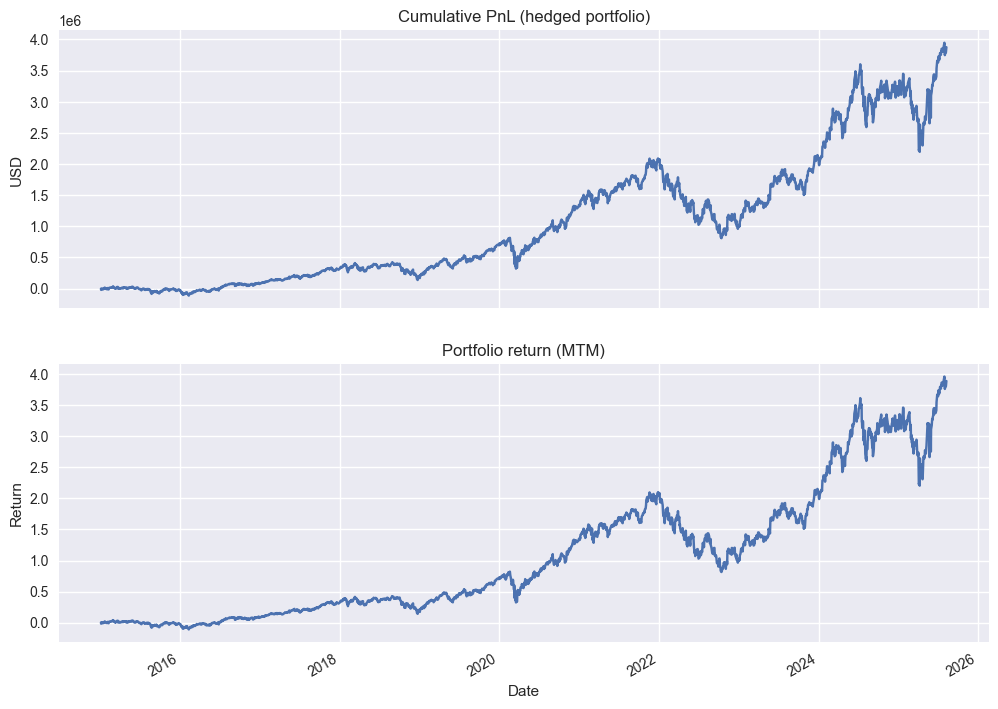

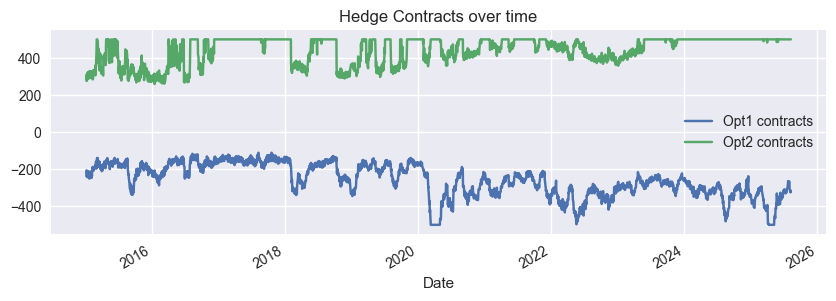

Saved data/phase4_hedge_results.csv and data/phase4_trade_log.csv


In [ ]:
# # -----------------------------
# # Phase 4: Hedging & Simulation (Full runnable cell, audited & fixed)
# # -----------------------------
# import os
# import math
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from datetime import timedelta
# from scipy.stats import norm
# from scipy.optimize import brentq
# import statsmodels.api as sm

# plt.style.use("seaborn-v0_8")
# pd.set_option("display.float_format", lambda x: f"{x:.4f}")

# # -----------------------------
# # 0) Local BSM and Greeks
# # -----------------------------
# def black_scholes_merton(S, K, T, r, sigma, option_type='call'):
#     if T <= 0:
#         return max(0.0, S - K) if option_type == 'call' else max(0.0, K - S)
#     d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
#     d2 = d1 - sigma * np.sqrt(T)
#     if option_type == 'call':
#         return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
#     else:
#         return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# def calculate_greeks(S, K, T, r, sigma, option_type='call'):
#     if T <= 0:
#         if option_type == 'call':
#             delta = 1.0 if S > K else 0.0
#         else:
#             delta = -1.0 if S < K else 0.0
#         return {'delta': delta, 'gamma': 0.0, 'vega': 0.0, 'theta': 0.0, 'rho': 0.0}
#     d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
#     d2 = d1 - sigma * np.sqrt(T)
#     pdf = norm.pdf(d1)
#     delta = norm.cdf(d1) if option_type == 'call' else (norm.cdf(d1)-1)
#     gamma = pdf / (S * sigma * np.sqrt(T))
#     vega = S * pdf * np.sqrt(T) / 100.0
#     return {'delta': delta, 'gamma': gamma, 'vega': vega, 'theta': None, 'rho': None}

# # -----------------------------
# # 1) Delta+Gamma solver (two options)
# # -----------------------------
# def solve_delta_gamma_two_options(
#     S, portfolio_value, portfolio_beta,
#     target_gamma_shares=0.0, opt1_params=None, opt2_params=None,
#     r=0.02, sigma=None, contract_multiplier=100
# ):
#     def get_info(p):
#         K = float(p['K']); T = float(p['T']); typ = p.get('type','call')
#         price = p.get('price', None)
#         if price is None:
#             if sigma is None:
#                 raise ValueError("Supply price or sigma for BSM pricing.")
#             price = black_scholes_merton(S, K, T, r, sigma, option_type=typ)
#         greeks = calculate_greeks(S, K, T, r, sigma if sigma is not None else 0.2, option_type=typ)
#         return {'K':K,'T':T,'type':typ,'price':price,'delta':greeks['delta'],'gamma':greeks['gamma']}
#     o1 = get_info(opt1_params); o2 = get_info(opt2_params)

#     portfolio_delta_shares = float(portfolio_beta) * float(portfolio_value) / float(S)  # shares-equiv
#     d1_pc = o1['delta'] * contract_multiplier
#     d2_pc = o2['delta'] * contract_multiplier
#     g1_pc = o1['gamma'] * contract_multiplier
#     g2_pc = o2['gamma'] * contract_multiplier

#     A = np.array([[d1_pc, d2_pc],
#                   [g1_pc, g2_pc]], dtype=float)
#     b = np.array([-portfolio_delta_shares, -target_gamma_shares], dtype=float)

#     res = {'o1':o1,'o2':o2,'A':A,'b':b}
#     det = np.linalg.det(A)
#     res['det'] = det
#     if not np.isfinite(det) or abs(det) < 1e-6:  # tighter threshold to avoid silly sizes
#         res['status']='singular'
#         return res

#     x, y = np.linalg.solve(A, b)
#     res['contracts_raw']={'opt1':x,'opt2':y}
#     res['costs'] = {'opt1_usd': x*o1['price']*contract_multiplier,
#                     'opt2_usd': y*o2['price']*contract_multiplier}
#     achieved_delta = d1_pc*x + d2_pc*y
#     achieved_gamma = g1_pc*x + g2_pc*y
#     res['achieved'] = {'delta_shares': achieved_delta, 'gamma_shares': achieved_gamma}
#     res['residuals'] = {'delta_resid_shares': achieved_delta + portfolio_delta_shares,
#                         'gamma_resid_shares': achieved_gamma + target_gamma_shares}
#     res['status']='ok'
#     return res

# # -----------------------------
# # 2) Backtest config (editable)
# # -----------------------------
# hedge_underlying = 'SPY'
# if hedge_underlying not in assets.columns:
#     raise RuntimeError(f"{hedge_underlying} missing from assets. Run Phase 1/2 to fetch it.")

# contract_multiplier = 100             # SPY options multiplier
# days_to_expiry = 30
# vol_window = 21
# rebalance = 'daily'                   # or 'weekly'
# do_gamma_hedge = True                 # use two-option delta+gamma solve
# target_gamma_shares = 0.0             # desire net gamma ~ 0
# max_abs_contracts = 500               # guard-rail cap

# # costs
# commission_per_contract = 0.65
# option_half_spread = 0.02
# slippage = 0.0005

# # initial capital / starting weights
# weights_file = "data/phase3_weights_with_constraints.csv"
# if os.path.exists(weights_file):
#     w_df = pd.read_csv(weights_file, index_col=0)
#     w0 = w_df.iloc[:,0]
#     print("Loaded weights from", weights_file)
# else:
#     try:
#         w0 = w_ms.copy()
#         print("Using w_ms from session.")
#     except Exception:
#         w0 = pd.Series(1.0/len(tickers), index=tickers)
#         print("Using equal-weight fallback for initial portfolio.")

# initial_portfolio_value = 1_000_000.0
# # <-- NEW: Configuration for Rolling Betas -->
# beta_recalc_freq = 'monthly' # 'monthly', 'quarterly', etc.
# beta_lookback_days = 252       # Use 1 year of past data to calculate beta


# # -----------------------------
# # 3) Build daily series / precompute vol & rf
# # -----------------------------
# prices  = assets.sort_index().copy()
# returns = prices.pct_change().dropna()
# spy_vol = (returns[hedge_underlying].rolling(vol_window).std() * np.sqrt(252)).fillna(method='bfill')
# dates   = prices.index.intersection(spy_vol.index)

# # risk-free default + optional override from rf series
# r_annual = 0.02
# try:
#     rf_series = rf['DGS3MO'].reindex(dates).ffill() / 100.0
#     if np.isfinite(rf_series.iloc[-1]):
#         r_annual = float(rf_series.iloc[-1])
# except Exception:
#     pass

# # initial holdings
# start = dates[0]
# start_prices = prices.loc[start]
# holdings_shares = pd.DataFrame(0.0, index=dates, columns=prices.columns)
# initial_shares = (w0 * initial_portfolio_value / start_prices).reindex(prices.columns).fillna(0)
# holdings_shares.iloc[0] = initial_shares.values
# cash = pd.Series(0.0, index=dates)
# cash.iloc[0] = initial_portfolio_value - (initial_shares * start_prices).sum()

# # option trackers
# opt1_pos = pd.Series(0.0, index=dates)
# opt2_pos = pd.Series(0.0, index=dates)
# trade_costs = pd.Series(0.0, index=dates)
# premium_flows = pd.Series(0.0, index=dates)   # new: actual cash paid/received for premiums
# mtm_portfolio = pd.Series(0.0, index=dates)
# mtm_hedge = pd.Series(0.0, index=dates)
# pnl = pd.Series(0.0, index=dates)
# trade_log = []

# def atm_strike(S):
#     return float(round(S))

# # static betas via OLS
# betas = {}
# for col in prices.columns:
#     if col == hedge_underlying:
#         betas[col] = 1.0
#         continue
#     try:
#         align = pd.concat([returns[col], returns[hedge_underlying]], axis=1).dropna()
#         X = sm.add_constant(align[hedge_underlying])
#         mod = sm.OLS(align[col], X).fit()
#         betas[col] = float(mod.params[hedge_underlying])
#     except Exception:
#         betas[col] = 0.0
# betas = pd.Series(betas)

# # -----------------------------
# # 4) Backtest loop
# # -----------------------------
# last_reb = start
# for i, today in enumerate(dates):
#     S = prices.loc[today, hedge_underlying]
#     sigma = spy_vol.loc[today] if not np.isnan(spy_vol.loc[today]) else 0.2
#     T = days_to_expiry / 252.0

#     # pick two options (same expiry), price them separately
#     K1 = round(S)             # ATM
#     K2 = round(S * 1.05)      # 5% OTM call (kept your choice)
#     price1 = black_scholes_merton(S, K1, T, r_annual, sigma, option_type='call')
#     price2 = black_scholes_merton(S, K2, T, r_annual, sigma, option_type='call')
#     g1 = calculate_greeks(S, K1, T, r_annual, sigma, option_type='call')
#     g2 = calculate_greeks(S, K2, T, r_annual, sigma, option_type='call')
#     delta1_per_contract = g1['delta'] * contract_multiplier
#     gamma1_per_contract = g1['gamma'] * contract_multiplier
#     delta2_per_contract = g2['delta'] * contract_multiplier
#     gamma2_per_contract = g2['gamma'] * contract_multiplier

#     # current MTM of shares
#     share_value = (holdings_shares.loc[today] * prices.loc[today]).fillna(0)
#     # use last known option positions at 'today'
#     port_value = (share_value.sum()
#                   + opt1_pos.loc[today]*price1*contract_multiplier
#                   + opt2_pos.loc[today]*price2*contract_multiplier
#                   + cash.loc[today])
#     if port_value == 0:
#         port_value = initial_portfolio_value

#     # weights & portfolio beta
#     mv_weights = share_value / share_value.sum() if share_value.sum() > 0 else pd.Series(0, index=share_value.index)
#     portfolio_beta = float((mv_weights.reindex(betas.index).fillna(0).values * betas.values).sum())

#     # delta (shares-equiv) of portfolio vs SPY
#     portfolio_delta_shares = portfolio_beta * port_value / S

#     # rebalance decision (daily)
#     do_rebalance = (rebalance == 'daily') or (rebalance == 'weekly' and (today - last_reb).days >= 7)

#     premium_flow_today = 0.0
#     if do_rebalance:
#         if do_gamma_hedge:
#             opt1 = {'K': K1, 'T': T, 'type':'call', 'price': price1}
#             opt2 = {'K': K2, 'T': T, 'type':'call', 'price': price2}
#             solver = solve_delta_gamma_two_options(S, port_value, portfolio_beta,
#                                                   target_gamma_shares=target_gamma_shares,
#                                                   opt1_params=opt1, opt2_params=opt2,
#                                                   r=r_annual, sigma=sigma,
#                                                   contract_multiplier=contract_multiplier)
#             if solver.get('status') == 'ok':
#                 target_opt1 = solver['contracts_raw']['opt1']
#                 target_opt2 = solver['contracts_raw']['opt2']
#                 new_opt1 = int(np.clip(np.round(target_opt1), -max_abs_contracts, max_abs_contracts))
#                 new_opt2 = int(np.clip(np.round(target_opt2), -max_abs_contracts, max_abs_contracts))
#             else:
#                 # fallback: delta-only using option 1
#                 if delta1_per_contract == 0:
#                     new_opt1 = 0; new_opt2 = 0
#                 else:
#                     new_opt1 = int(np.clip(np.round(-portfolio_delta_shares / delta1_per_contract),
#                                            -max_abs_contracts, max_abs_contracts))
#                     new_opt2 = 0
#         else:
#             # delta-only using ATM option 1
#             if delta1_per_contract == 0:
#                 new_opt1 = 0
#             else:
#                 new_opt1 = int(np.clip(np.round(-portfolio_delta_shares / delta1_per_contract),
#                                        -max_abs_contracts, max_abs_contracts))
#             new_opt2 = 0

#         # trades, costs, and premium cash flows
#         prev1 = opt1_pos.iloc[i-1] if i>0 else 0.0
#         prev2 = opt2_pos.iloc[i-1] if i>0 else 0.0
#         dq1 = new_opt1 - prev1
#         dq2 = new_opt2 - prev2

#         # commissions + spreads + slippage
#         tc1 = abs(dq1) * (commission_per_contract + option_half_spread * price1 * contract_multiplier + slippage * price1 * contract_multiplier)
#         tc2 = abs(dq2) * (commission_per_contract + option_half_spread * price2 * contract_multiplier + slippage * price2 * contract_multiplier)
#         trade_costs.iloc[i] += tc1 + tc2

#         # **premium cash flow** (buying consumes cash; shorting adds cash)
#         premium_flow_today = -(dq1 * price1 + dq2 * price2) * contract_multiplier

#         trade_log.append((today, 'option1', prev1, new_opt1, tc1))
#         trade_log.append((today, 'option2', prev2, new_opt2, tc2))
#         opt1_pos.iloc[i] = new_opt1
#         opt2_pos.iloc[i] = new_opt2
#         last_reb = today
#     else:
#         # carry forward positions
#         opt1_pos.iloc[i] = opt1_pos.iloc[i-1] if i>0 else 0.0
#         opt2_pos.iloc[i] = opt2_pos.iloc[i-1] if i>0 else 0.0

#     premium_flows.iloc[i] = premium_flow_today

#     # MTM with correct prices per leg
#     mtm_option_value = (opt1_pos.loc[today] * price1 + opt2_pos.loc[today] * price2) * contract_multiplier
#     mtm_shares_value = (holdings_shares.loc[today] * prices.loc[today]).sum()
#     # update cash (include premium flows + costs)
#     if i == 0:
#         cash.iloc[i] = cash.iloc[i] + premium_flow_today - trade_costs.iloc[i]
#     else:
#         cash.iloc[i] = cash.iloc[i-1] + premium_flow_today - trade_costs.iloc[i]
#     mtm_portfolio.loc[today] = mtm_shares_value + mtm_option_value + cash.loc[today]
#     mtm_hedge.loc[today] = mtm_option_value

#     # PnL (change in MTM minus today’s explicit costs; premium already captured via cash)
#     if i == 0:
#         pnl.iloc[i] = mtm_portfolio.iloc[i] - initial_portfolio_value
#     else:
#         pnl.iloc[i] = mtm_portfolio.iloc[i] - mtm_portfolio.iloc[i-1]

#     # carry forward for next day
#     if i+1 < len(dates):
#         holdings_shares.iloc[i+1] = holdings_shares.iloc[i]
#         opt1_pos.iloc[i+1] = opt1_pos.iloc[i]
#         opt2_pos.iloc[i+1] = opt2_pos.iloc[i]
#         cash.iloc[i+1] = cash.iloc[i]

# # -----------------------------
# # 5) Results, plots, save
# # -----------------------------
# results = pd.DataFrame({
#     'mtm_portfolio': mtm_portfolio,
#     'mtm_hedge': mtm_hedge,
#     'opt1_contracts': opt1_pos,
#     'opt2_contracts': opt2_pos,
#     'trade_costs': trade_costs,
#     'premium_flows': premium_flows,
#     'pnl': pnl,
#     'cash': cash
# })
# results['cum_pnl'] = results['pnl'].cumsum()
# results['portfolio_return'] = results['mtm_portfolio'] / results['mtm_portfolio'].iloc[0] - 1.0

# print("Final MTM value:", float(mtm_portfolio.iloc[-1]))
# print("Total commissions/slippage:", float(trade_costs.sum()))
# print("Net option premium flows:", float(premium_flows.sum()))

# # Plots
# fig, ax = plt.subplots(2,1, figsize=(12,9), sharex=True)
# results['cum_pnl'].plot(ax=ax[0], title='Cumulative PnL (hedged portfolio)')
# ax[0].set_ylabel('USD')
# results['portfolio_return'].plot(ax=ax[1], title='Portfolio return (MTM)')
# ax[1].set_ylabel('Return')
# plt.show()

# plt.figure(figsize=(10,3))
# results['opt1_contracts'].plot(label='Opt1 contracts')
# results['opt2_contracts'].plot(label='Opt2 contracts')
# plt.title('Hedge Contracts over time')
# plt.legend(); plt.grid(True); plt.show()

# os.makedirs('data', exist_ok=True)
# results.to_csv('data/phase4_hedge_results.csv')
# pd.DataFrame(trade_log, columns=['date','instrument','prev','new','cost']).to_csv('data/phase4_trade_log.csv')
# print("Saved data/phase4_hedge_results.csv and data/phase4_trade_log.csv")


Using w_ms from session.


C:\Users\91983\AppData\Local\Temp\ipykernel_33808\2180506565.py:133: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()
C:\Users\91983\AppData\Local\Temp\ipykernel_33808\2180506565.py:134: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy_vol = (returns[hedge_underlying].rolling(vol_window).std() * np.sqrt(252)).fillna(method='bfill')
C:\Users\91983\AppData\Local\Temp\ipykernel_33808\2180506565.py:169: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets_win = prices_win

Final MTM value: 4785922.807890866
Total commissions/slippage: 631025.3971230295
Net option premium flows: 188998.43067596285


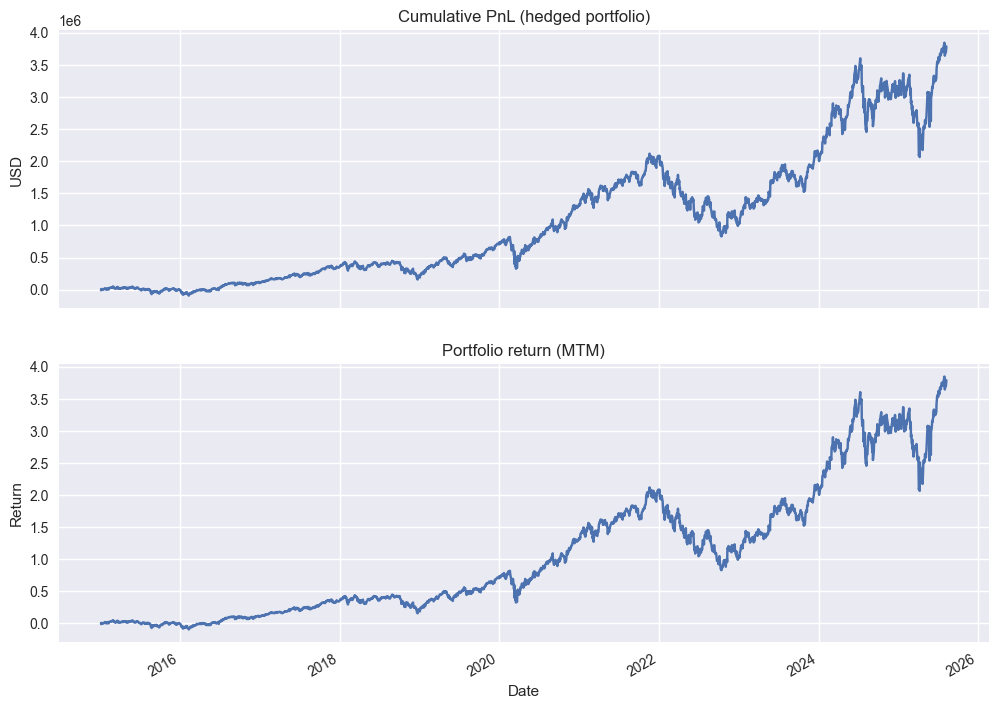

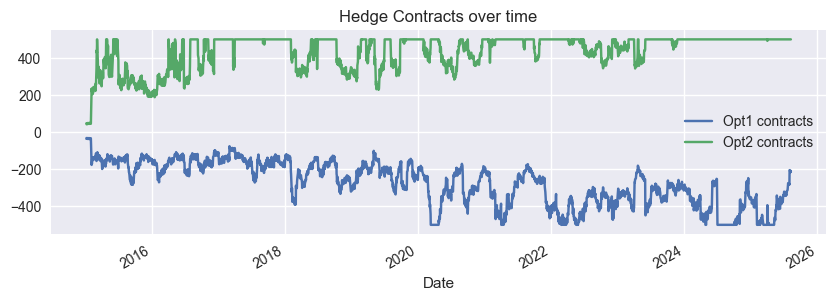

In [ ]:
# -----------------------------
# Phase 4: Hedging & Simulation (Full runnable cell, with rolling betas)
# -----------------------------
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.stats import norm
from scipy.optimize import brentq
import statsmodels.api as sm

plt.style.use("seaborn-v0_8")
pd.set_option("display.float_format", lambda x: f"{x:.4f}")

# -----------------------------
# 0) Local BSM and Greeks
# -----------------------------
def black_scholes_merton(S, K, T, r, sigma, option_type='call'):
    if T <= 0:
        return max(0.0, S - K) if option_type == 'call' else max(0.0, K - S)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:
        return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def calculate_greeks(S, K, T, r, sigma, option_type='call'):
    if T <= 0:
        if option_type == 'call':
            delta = 1.0 if S > K else 0.0
        else:
            delta = -1.0 if S < K else 0.0
        return {'delta': delta, 'gamma': 0.0, 'vega': 0.0, 'theta': 0.0, 'rho': 0.0}
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    pdf = norm.pdf(d1)
    delta = norm.cdf(d1) if option_type == 'call' else (norm.cdf(d1)-1)
    gamma = pdf / (S * sigma * np.sqrt(T))
    vega = S * pdf * np.sqrt(T) / 100.0
    return {'delta': delta, 'gamma': gamma, 'vega': vega, 'theta': None, 'rho': None}

# -----------------------------
# 1) Delta+Gamma solver (two options)
# -----------------------------
def solve_delta_gamma_two_options(
    S, portfolio_value, portfolio_beta,
    target_gamma_shares=0.0, opt1_params=None, opt2_params=None,
    r=0.02, sigma=None, contract_multiplier=100
):
    def get_info(p):
        K = float(p['K']); T = float(p['T']); typ = p.get('type','call')
        price = p.get('price', None)
        if price is None:
            if sigma is None:
                raise ValueError("Supply price or sigma for BSM pricing.")
            price = black_scholes_merton(S, K, T, r, sigma, option_type=typ)
        greeks = calculate_greeks(S, K, T, r, sigma if sigma is not None else 0.2, option_type=typ)
        return {'K':K,'T':T,'type':typ,'price':price,'delta':greeks['delta'],'gamma':greeks['gamma']}
    o1 = get_info(opt1_params); o2 = get_info(opt2_params)

    portfolio_delta_shares = float(portfolio_beta) * float(portfolio_value) / float(S)  # shares-equiv
    d1_pc = o1['delta'] * contract_multiplier
    d2_pc = o2['delta'] * contract_multiplier
    g1_pc = o1['gamma'] * contract_multiplier
    g2_pc = o2['gamma'] * contract_multiplier

    A = np.array([[d1_pc, d2_pc],
                  [g1_pc, g2_pc]], dtype=float)
    b = np.array([-portfolio_delta_shares, -target_gamma_shares], dtype=float)

    res = {'o1':o1,'o2':o2,'A':A,'b':b}
    det = np.linalg.det(A)
    res['det'] = det
    if not np.isfinite(det) or abs(det) < 1e-6:
        res['status']='singular'
        return res

    x, y = np.linalg.solve(A, b)
    res['contracts_raw']={'opt1':x,'opt2':y}
    res['costs'] = {'opt1_usd': x*o1['price']*contract_multiplier,
                    'opt2_usd': y*o2['price']*contract_multiplier}
    achieved_delta = d1_pc*x + d2_pc*y
    achieved_gamma = g1_pc*x + g2_pc*y
    res['achieved'] = {'delta_shares': achieved_delta, 'gamma_shares': achieved_gamma}
    res['residuals'] = {'delta_resid_shares': achieved_delta + portfolio_delta_shares,
                        'gamma_resid_shares': achieved_gamma + target_gamma_shares}
    res['status']='ok'
    return res

# -----------------------------
# 2) Backtest config (editable)
# -----------------------------
hedge_underlying = 'SPY'
if hedge_underlying not in assets.columns:
    raise RuntimeError(f"{hedge_underlying} missing from assets. Run Phase 1/2 to fetch it.")

contract_multiplier = 100
days_to_expiry = 30
vol_window = 21
rebalance = 'daily'
do_gamma_hedge = True
target_gamma_shares = 0.0
max_abs_contracts = 500

commission_per_contract = 0.65
option_half_spread = 0.02
slippage = 0.0005

weights_file = "x"
if os.path.exists(weights_file):
    w_df = pd.read_csv(weights_file, index_col=0)
    w0 = w_df.iloc[:,0]
    print("Loaded weights from", weights_file)
else:
    try:
        w0 = w_ms.copy()
        print("Using w_ms from session.")
    except Exception:
        w0 = pd.Series(1.0/len(tickers), index=tickers)
        print("Using equal-weight fallback for initial portfolio.")

initial_portfolio_value = 1_000_000.0
beta_recalc_freq = 'monthly'  # 'monthly', 'quarterly', etc.
beta_lookback_days = 30

# -----------------------------
# 3) Build daily series / precompute vol & rf
# -----------------------------
prices  = assets.sort_index().copy()
returns = prices.pct_change().dropna()
spy_vol = (returns[hedge_underlying].rolling(vol_window).std() * np.sqrt(252)).fillna(method='bfill')
dates   = prices.index.intersection(spy_vol.index)

r_annual = 0.02
try:
    rf_series = rf['DGS3MO'].reindex(dates).ffill() / 100.0
    if np.isfinite(rf_series.iloc[-1]):
        r_annual = float(rf_series.iloc[-1])
except Exception:
    pass

start = dates[0]
start_prices = prices.loc[start]
holdings_shares = pd.DataFrame(0.0, index=dates, columns=prices.columns)
initial_shares = (w0 * initial_portfolio_value / start_prices).reindex(prices.columns).fillna(0)
holdings_shares.iloc[0] = initial_shares.values
cash = pd.Series(0.0, index=dates)
cash.iloc[0] = initial_portfolio_value - (initial_shares * start_prices).sum()

opt1_pos = pd.Series(0.0, index=dates)
opt2_pos = pd.Series(0.0, index=dates)
trade_costs = pd.Series(0.0, index=dates)
premium_flows = pd.Series(0.0, index=dates)
mtm_portfolio = pd.Series(0.0, index=dates)
mtm_hedge = pd.Series(0.0, index=dates)
pnl = pd.Series(0.0, index=dates)
trade_log = []

def atm_strike(S):
    return float(round(S))

# -----------------------------
# Rolling beta calculation
# -----------------------------
def calc_beta_window(prices_window, hedge_underlying):
    rets_win = prices_window.pct_change().dropna()
    betas = {}
    for col in prices_window.columns:
        if col == hedge_underlying:
            betas[col] = 1.0
            continue
        try:
            align = pd.concat([rets_win[col], rets_win[hedge_underlying]], axis=1).dropna()
            X = sm.add_constant(align[hedge_underlying])
            mod = sm.OLS(align[col], X).fit()
            betas[col] = float(mod.params[hedge_underlying])
        except Exception:
            betas[col] = 0.0
    return pd.Series(betas)

rolling_betas = pd.DataFrame(index=dates, columns=prices.columns, dtype=float)
last_beta_calc_date = None
betas_last_period = None

for current_date in dates:
    recalc_needed = (
        last_beta_calc_date is None or
        beta_recalc_freq == 'daily' or
        (beta_recalc_freq == 'weekly' and (current_date - last_beta_calc_date).days >= 7) or
        (beta_recalc_freq == 'monthly' and current_date.month != last_beta_calc_date.month) or
        (beta_recalc_freq == 'quarterly' and (current_date.to_period('Q') != last_beta_calc_date.to_period('Q')))
    )
    if recalc_needed:
        lookback_end = current_date - pd.Timedelta(days=1)
        start_win = lookback_end - pd.Timedelta(days=beta_lookback_days)
        price_window = prices.loc[(prices.index >= start_win) & (prices.index <= lookback_end)]
        betas_last_period = calc_beta_window(price_window, hedge_underlying)
        last_beta_calc_date = current_date
    rolling_betas.loc[current_date] = betas_last_period
rolling_betas = rolling_betas.ffill()

# -----------------------------
# 4) Backtest loop
# -----------------------------
last_reb = start
for i, today in enumerate(dates):
    S = prices.loc[today, hedge_underlying]
    sigma = spy_vol.loc[today] if not np.isnan(spy_vol.loc[today]) else 0.2
    T = days_to_expiry / 252.0

    K1 = round(S)
    K2 = round(S * 1.05)
    price1 = black_scholes_merton(S, K1, T, r_annual, sigma, option_type='call')
    price2 = black_scholes_merton(S, K2, T, r_annual, sigma, option_type='call')
    g1 = calculate_greeks(S, K1, T, r_annual, sigma, option_type='call')
    g2 = calculate_greeks(S, K2, T, r_annual, sigma, option_type='call')
    delta1_per_contract = g1['delta'] * contract_multiplier
    gamma1_per_contract = g1['gamma'] * contract_multiplier
    delta2_per_contract = g2['delta'] * contract_multiplier
    gamma2_per_contract = g2['gamma'] * contract_multiplier

    share_value = (holdings_shares.loc[today] * prices.loc[today]).fillna(0)
    port_value = (share_value.sum()
                  + opt1_pos.loc[today]*price1*contract_multiplier
                  + opt2_pos.loc[today]*price2*contract_multiplier
                  + cash.loc[today])
    if port_value == 0:
        port_value = initial_portfolio_value

    mv_weights = share_value / share_value.sum() if share_value.sum() > 0 else pd.Series(0, index=share_value.index)
    portfolio_beta = float((mv_weights.reindex(rolling_betas.columns).fillna(0).values *
                            rolling_betas.loc[today].values).sum())

    portfolio_delta_shares = portfolio_beta * port_value / S

    do_rebalance = (rebalance == 'daily') or (rebalance == 'weekly' and (today - last_reb).days >= 7)

    premium_flow_today = 0.0
    if do_rebalance:
        if do_gamma_hedge:
            opt1 = {'K': K1, 'T': T, 'type':'call', 'price': price1}
            opt2 = {'K': K2, 'T': T, 'type':'call', 'price': price2}
            solver = solve_delta_gamma_two_options(S, port_value, portfolio_beta,
                                                  target_gamma_shares=target_gamma_shares,
                                                  opt1_params=opt1, opt2_params=opt2,
                                                  r=r_annual, sigma=sigma,
                                                  contract_multiplier=contract_multiplier)
            if solver.get('status') == 'ok':
                target_opt1 = solver['contracts_raw']['opt1']
                target_opt2 = solver['contracts_raw']['opt2']
                new_opt1 = int(np.clip(np.round(target_opt1), -max_abs_contracts, max_abs_contracts))
                new_opt2 = int(np.clip(np.round(target_opt2), -max_abs_contracts, max_abs_contracts))
            else:
                if delta1_per_contract == 0:
                    new_opt1 = 0; new_opt2 = 0
                else:
                    new_opt1 = int(np.clip(np.round(-portfolio_delta_shares / delta1_per_contract),
                                           -max_abs_contracts, max_abs_contracts))
                    new_opt2 = 0
        else:
            if delta1_per_contract == 0:
                new_opt1 = 0
            else:
                new_opt1 = int(np.clip(np.round(-portfolio_delta_shares / delta1_per_contract),
                                       -max_abs_contracts, max_abs_contracts))
            new_opt2 = 0

        prev1 = opt1_pos.iloc[i-1] if i>0 else 0.0
        prev2 = opt2_pos.iloc[i-1] if i>0 else 0.0
        dq1 = new_opt1 - prev1
        dq2 = new_opt2 - prev2

        tc1 = abs(dq1) * (commission_per_contract + option_half_spread * price1 * contract_multiplier + slippage * price1 * contract_multiplier)
        tc2 = abs(dq2) * (commission_per_contract + option_half_spread * price2 * contract_multiplier + slippage * price2 * contract_multiplier)
        trade_costs.iloc[i] += tc1 + tc2

        premium_flow_today = -(dq1 * price1 + dq2 * price2) * contract_multiplier

        trade_log.append((today, 'option1', prev1, new_opt1, tc1))
        trade_log.append((today, 'option2', prev2, new_opt2, tc2))
        opt1_pos.iloc[i] = new_opt1
        opt2_pos.iloc[i] = new_opt2
        last_reb = today
    else:
        opt1_pos.iloc[i] = opt1_pos.iloc[i-1] if i>0 else 0.0
        opt2_pos.iloc[i] = opt2_pos.iloc[i-1] if i>0 else 0.0

    premium_flows.iloc[i] = premium_flow_today

    mtm_option_value = (opt1_pos.loc[today] * price1 + opt2_pos.loc[today] * price2) * contract_multiplier
    mtm_shares_value = (holdings_shares.loc[today] * prices.loc[today]).sum()
    if i == 0:
        cash.iloc[i] = cash.iloc[i] + premium_flow_today - trade_costs.iloc[i]
    else:
        cash.iloc[i] = cash.iloc[i-1] + premium_flow_today - trade_costs.iloc[i]
    mtm_portfolio.loc[today] = mtm_shares_value + mtm_option_value + cash.loc[today]
    mtm_hedge.loc[today] = mtm_option_value

    if i == 0:
        pnl.iloc[i] = mtm_portfolio.iloc[i] - initial_portfolio_value
    else:
        pnl.iloc[i] = mtm_portfolio.iloc[i] - mtm_portfolio.iloc[i-1]

    if i+1 < len(dates):
        holdings_shares.iloc[i+1] = holdings_shares.iloc[i]
        opt1_pos.iloc[i+1] = opt1_pos.iloc[i]
        opt2_pos.iloc[i+1] = opt2_pos.iloc[i]
        cash.iloc[i+1] = cash.iloc[i]

# -----------------------------
# 5) Results, plots, save
# -----------------------------
results = pd.DataFrame({
    'mtm_portfolio': mtm_portfolio,
    'mtm_hedge': mtm_hedge,
    'opt1_contracts': opt1_pos,
    'opt2_contracts': opt2_pos,
    'trade_costs': trade_costs,
    'premium_flows': premium_flows,
    'pnl': pnl,
    'cash': cash
})
results['cum_pnl'] = results['pnl'].cumsum()
results['portfolio_return'] = results['mtm_portfolio'] / results['mtm_portfolio'].iloc[0] - 1.0

print("Final MTM value:", float(mtm_portfolio.iloc[-1]))
print("Total commissions/slippage:", float(trade_costs.sum()))
print("Net option premium flows:", float(premium_flows.sum()))

fig, ax = plt.subplots(2,1, figsize=(12,9), sharex=True)
results['cum_pnl'].plot(ax=ax[0], title='Cumulative PnL (hedged portfolio)')
ax[0].set_ylabel('USD')
results['portfolio_return'].plot(ax=ax[1], title='Portfolio return (MTM)')
ax[1].set_ylabel('Return')
plt.show()

plt.figure(figsize=(10,3))
results['opt1_contracts'].plot(label='Opt1 contracts')
results['opt2_contracts'].plot(label='Opt2 contracts')
plt.title('Hedge Contracts over time')
plt.legend(); plt.grid(True); plt.show()

os.makedirs('data', exist_ok=True)
results.to_csv('data/phase4_hedge_results.csv')


=== Phase 5 — Summary Metrics ===
Period: 2015-01-05 to 2025-08-08  (n=2665)
Annualized return: 15.9624%
Annualized vol:    24.6075%
Sharpe (ann):      0.723
Sortino:           0.836
Max Drawdown:      -41.3447%  (from 2021-11-19 00:00:00 to 2022-10-14 00:00:00, 329 days)
Calmar:            0.386
VaR95 hist (daily): 2.3441%, CVaR95 hist: 3.6724%
VaR99 hist (daily): 4.2827%, CVaR99 hist: 6.1865%
VaR95 param (daily): 2.4789%, CVaR95 param: 3.1267%
Beta vs SPY: 1.101, Corr: 0.804
Recon check (shares+options+cash == NAV): True


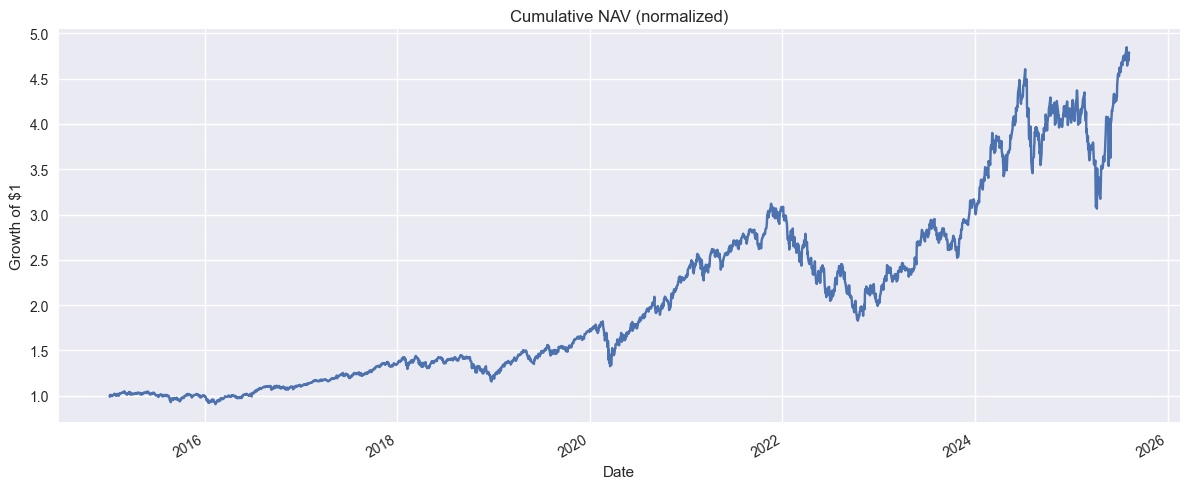

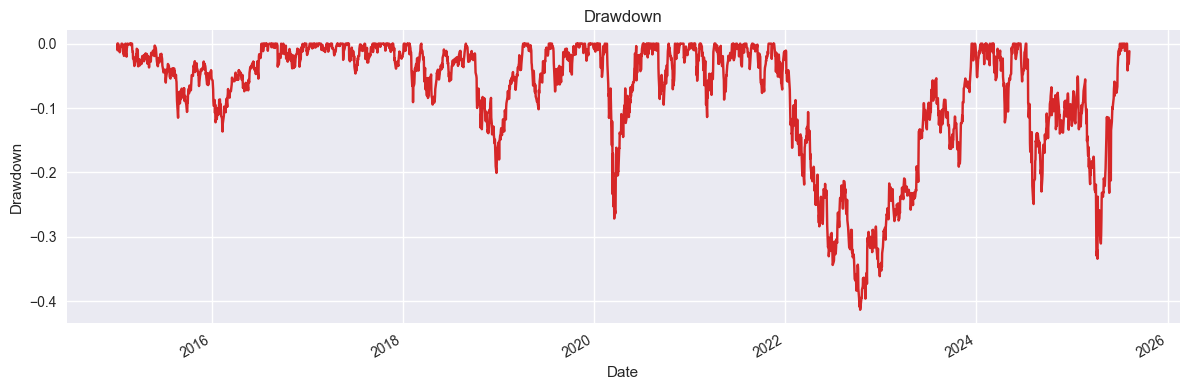

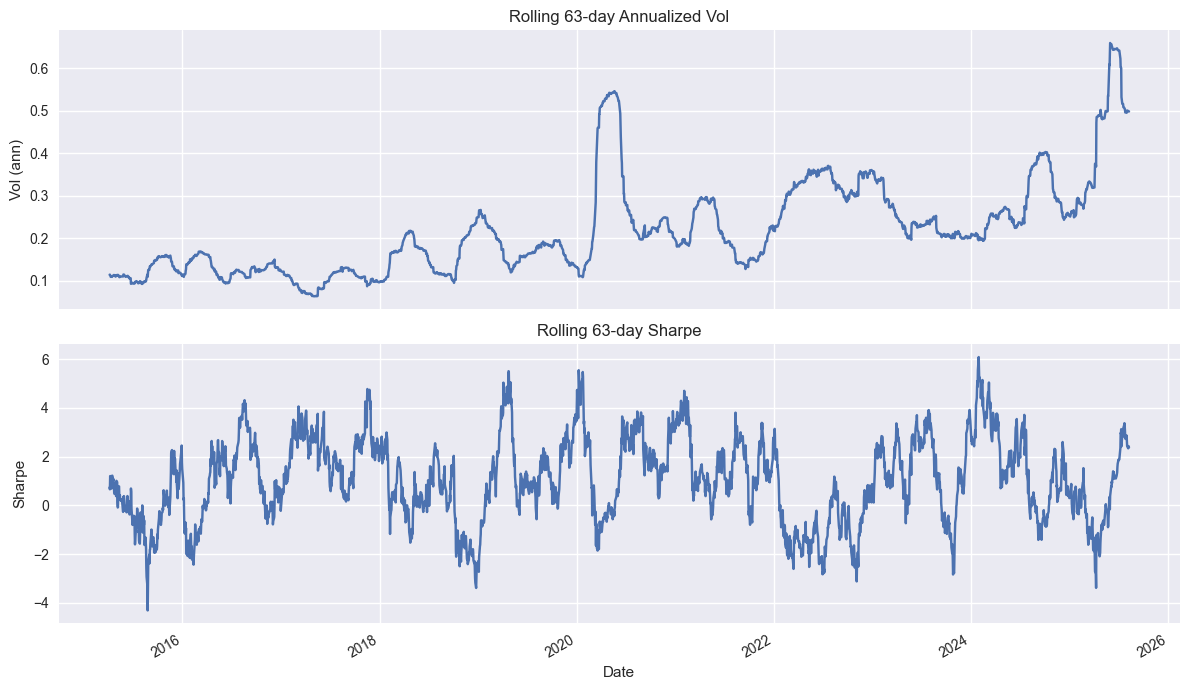

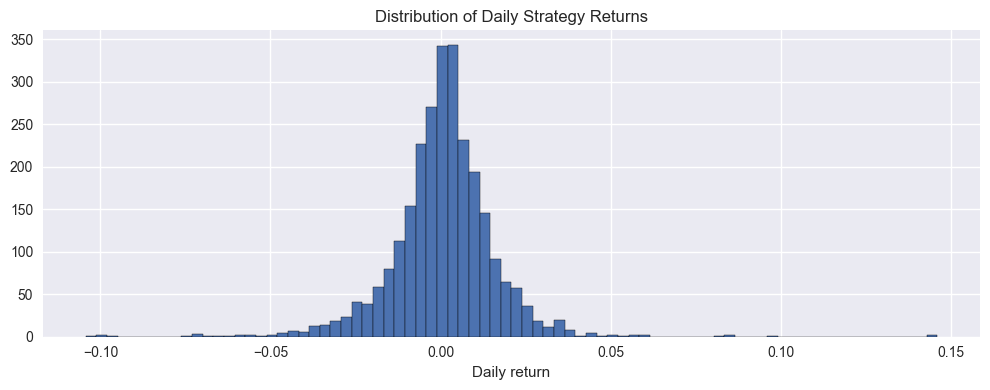

C:\Users\91983\AppData\Local\Temp\ipykernel_33808\4240970369.py:237: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.DataFrame({'opt1': opt1_pos.reindex(dates).fillna(method='ffill'),
C:\Users\91983\AppData\Local\Temp\ipykernel_33808\4240970369.py:238: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'opt2': opt2_pos.reindex(dates).fillna(method='ffill')}).plot()


<Figure size 1200x300 with 0 Axes>

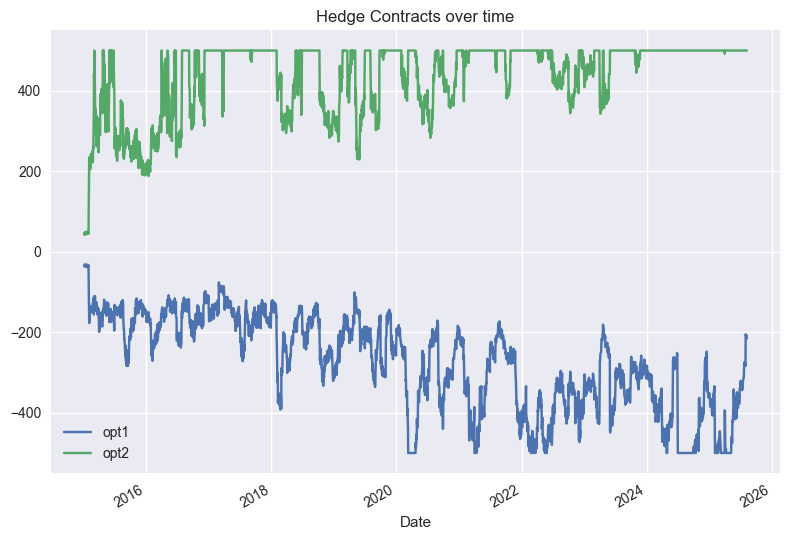

<Figure size 1000x400 with 0 Axes>

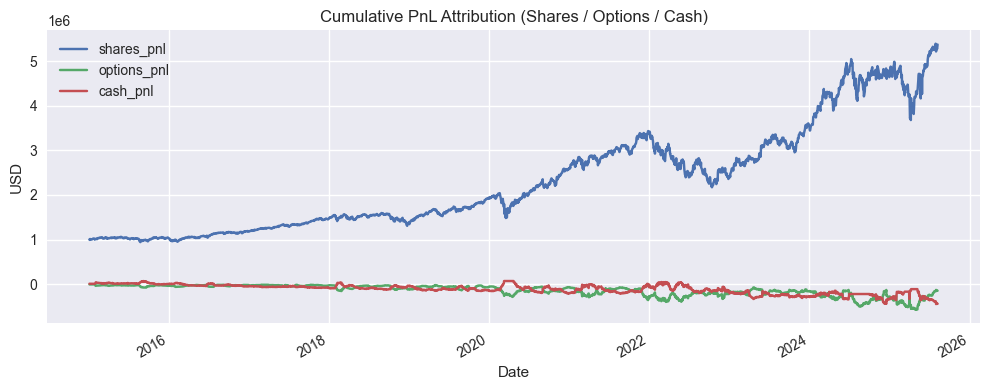


Saved phase 5 artifacts to ./data/:
 - phase5_cumulative_nav.png
 - phase5_drawdown.png
 - phase5_rolling_metrics.png
 - phase5_return_hist.png
 - phase5_contracts.png (if opt positions present)
 - phase5_attribution_cumulative.png
 - phase5_results_snapshot.csv
 - phase5_daily_components_pnl.csv
 - phase5_stress_episodes.csv
 - phase5_summary_metrics.csv

--- Diagnostic checks ---
Sample rolling betas (if available):
              QQQ    SMH   QUAL    SPY    TLT    IEF    PFF    TIP
Date                                                              
2015-01-05 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
2015-01-06 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
2015-01-07 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
2015-01-08 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
2015-01-09 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
2015-01-12 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
2015-01-13 0.0000 0.0000 0.0000 1.0000 0.

In [262]:
# -----------------------------
# Phase 5 — Backtesting, Risk Reporting & Tear Sheet
# Copy-paste this cell after your Phase 4 run
# -----------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.style.use("seaborn-v0_8")

# -----------------------------
# Sanity checks / required inputs
# -----------------------------
required = ['results', 'prices', 'holdings_shares', 'opt1_pos', 'opt2_pos',
            'trade_costs', 'premium_flows', 'cash', 'hedge_underlying',
            'r_annual', 'contract_multiplier']
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(f"Missing required variables from Phase 4: {missing}")

# Local aliases
nav = results['mtm_portfolio'].copy()
mtm_hedge = results.get('mtm_hedge', pd.Series(0.0, index=nav.index))
dates = nav.index.sort_values()

# Strategy daily returns (handle zeros / NaNs)
strategy_ret = nav.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Benchmark: if you have a benchmark series in environment use it, else use hedge_underlying returns
if 'benchmark_returns' in globals():
    benchmark_ret = benchmark_returns.reindex(dates).fillna(0.0)
else:
    # create benchmark returns from prices[hedge_underlying] if available
    if hedge_underlying not in prices.columns:
        raise RuntimeError(f"Benchmark not provided and {hedge_underlying} not found in prices.")
    benchmark_ret = prices[hedge_underlying].reindex(dates).pct_change().fillna(0.0)

# -----------------------------
# Helper metrics
# -----------------------------
TRADING_DAYS = 252

def ann_return(returns):
    returns = returns.dropna()
    if returns.empty:
        return np.nan
    cum = (1 + returns).prod()
    n = returns.shape[0]
    return cum ** (TRADING_DAYS / n) - 1

def ann_vol(returns):
    return returns.std(ddof=0) * np.sqrt(TRADING_DAYS)

def sharpe(returns, rf_annual=0.0):
    if returns.empty:
        return np.nan
    rf_daily = (1 + rf_annual) ** (1 / TRADING_DAYS) - 1
    ex = returns - rf_daily
    vol = returns.std(ddof=0)
    return np.nan if vol == 0 else ex.mean() / vol * np.sqrt(TRADING_DAYS)

def sortino(returns, rf_annual=0.0):
    returns = returns.dropna()
    rf_ann = rf_annual
    downside = returns[returns < 0]
    if downside.empty:
        return np.nan
    downside_std = downside.std(ddof=0) * np.sqrt(TRADING_DAYS)
    return (ann_return(returns) - rf_ann) / downside_std if downside_std != 0 else np.nan

def max_drawdown(series):
    # series is NAV (level)
    roll_max = series.cummax()
    dd = series / roll_max - 1.0
    mdd = dd.min()
    if pd.isna(mdd):
        return np.nan, None, None, dd
    end = dd.idxmin()
    start = series.loc[:end].idxmax()
    length = (end - start).days
    return float(mdd), start, end, length, dd

def var_cvar(returns, alpha=0.95, method='historical'):
    r = returns.dropna()
    if r.empty:
        return np.nan, np.nan
    if method == 'historical':
        var = -np.quantile(r, 1 - alpha)
        cvar = -r[r <= np.quantile(r, 1 - alpha)].mean()
        return float(var), float(cvar)
    else:
        mu = r.mean()
        sigma = r.std(ddof=0)
        if sigma == 0:
            return np.nan, np.nan
        z = norm.ppf(alpha)
        var = -(mu - z * sigma)
        cvar = -(mu - sigma * (norm.pdf(z) / (1 - alpha)))
        return float(var), float(cvar)

# -----------------------------
# Attribution (Shares / Options / Cash)
# -----------------------------
# compute time series of component values aligned to NAV index
shares_v = (holdings_shares.reindex(dates).multiply(prices.reindex(dates))).sum(axis=1).fillna(0.0)
options_v = mtm_hedge.reindex(dates).fillna(0.0)
cash_v = cash.reindex(dates).fillna(0.0)

# sanity recon
recon_ok = np.allclose((shares_v + options_v + cash_v).values, nav.fillna(0).values, atol=1e-6)

# daily component PnLs (level differences)
shares_pnl = shares_v.diff().fillna(shares_v.iloc[0])
options_pnl = options_v.diff().fillna(options_v.iloc[0])
cash_pnl = cash_v.diff().fillna(cash_v.iloc[0])

components_pnl = pd.DataFrame({
    'shares_pnl': shares_pnl,
    'options_pnl': options_pnl,
    'cash_pnl': cash_pnl
}, index=dates)
components_pnl['total_components'] = components_pnl.sum(axis=1)
reported_pnl = results['pnl'].reindex(dates).fillna(0.0)

# -----------------------------
# Point-in-time summary metrics
# -----------------------------
ann_ret = ann_return(strategy_ret)
annstd = ann_vol(strategy_ret)
sr = sharpe(strategy_ret, rf_annual=r_annual)
sort = sortino(strategy_ret, rf_annual=r_annual)
mdd, mdd_s, mdd_e, mdd_len, dd_series = max_drawdown(nav)
calmar = ann_ret / abs(mdd) if (ann_ret is not np.nan and mdd is not np.nan and mdd < 0) else np.nan

VaR95_h, CVaR95_h = var_cvar(strategy_ret, alpha=0.95, method='historical')
VaR99_h, CVaR99_h = var_cvar(strategy_ret, alpha=0.99, method='historical')
VaR95_p, CVaR95_p = var_cvar(strategy_ret, alpha=0.95, method='parametric')
VaR99_p, CVaR99_p = var_cvar(strategy_ret, alpha=0.99, method='parametric')

# Rolling metrics
rolling_vol_63 = strategy_ret.rolling(window=63).std(ddof=0) * np.sqrt(TRADING_DAYS)
rolling_sharpe_63 = (strategy_ret.rolling(63).mean() / strategy_ret.rolling(63).std(ddof=0)) * np.sqrt(TRADING_DAYS)

# Beta vs benchmark (use overlapping non-nan)
cov = np.cov(strategy_ret.fillna(0.0), benchmark_ret.fillna(0.0))
bench_var = np.var(benchmark_ret.fillna(0.0))
beta_vs_bench = cov[0,1] / bench_var if bench_var != 0 else np.nan
corr_vs_bench = strategy_ret.corr(benchmark_ret)

# Stress episodes to evaluate (common windows)
stress_list = [
    ("GFC", "2008-09-01", "2009-03-09"),
    ("COVID", "2020-02-19", "2020-03-23"),
    ("2022_drawdown", "2022-01-01", "2022-10-14"),
]
stress_results = []
for name, s, e in stress_list:
    try:
        sub_nav = nav.loc[(nav.index >= s) & (nav.index <= e)]
        if sub_nav.empty:
            stress_results.append((name, np.nan, np.nan, np.nan))
        else:
            ret = sub_nav.iloc[-1] / sub_nav.iloc[0] - 1.0
            mdd_sub, _, _, _, _ = max_drawdown(sub_nav)
            vol_sub = sub_nav.pct_change().dropna().std(ddof=0) * np.sqrt(TRADING_DAYS)
            stress_results.append((name, float(ret), float(mdd_sub), float(vol_sub)))
    except Exception:
        stress_results.append((name, np.nan, np.nan, np.nan))
stress_df = pd.DataFrame(stress_results, columns=['episode','return','max_drawdown','ann_vol'])
stress_df
# -----------------------------
# Output / Prints
# -----------------------------
print("=== Phase 5 — Summary Metrics ===")
print(f"Period: {dates[0].date()} to {dates[-1].date()}  (n={len(dates)})")
print(f"Annualized return: {ann_ret:.4%}")
print(f"Annualized vol:    {annstd:.4%}")
print(f"Sharpe (ann):      {sr:.3f}")
print(f"Sortino:           {sort:.3f}")
print(f"Max Drawdown:      {mdd:.4%}  (from {mdd_s} to {mdd_e}, {mdd_len} days)")
print(f"Calmar:            {calmar:.3f}")
print(f"VaR95 hist (daily): {VaR95_h:.4%}, CVaR95 hist: {CVaR95_h:.4%}")
print(f"VaR99 hist (daily): {VaR99_h:.4%}, CVaR99 hist: {CVaR99_h:.4%}")
print(f"VaR95 param (daily): {VaR95_p:.4%}, CVaR95 param: {CVaR95_p:.4%}")
print(f"Beta vs {hedge_underlying}: {beta_vs_bench:.3f}, Corr: {corr_vs_bench:.3f}")
print(f"Recon check (shares+options+cash == NAV): {recon_ok}")

# -----------------------------
# Plots – Tear sheet style
# -----------------------------
os.makedirs('data', exist_ok=True)

# 1) Cumulative NAV
plt.figure(figsize=(12,5))
(nav / nav.iloc[0]).plot()
plt.title("Cumulative NAV (normalized)")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.tight_layout()
plt.savefig('data/phase5_cumulative_nav.png', dpi=150)
plt.show()

# 2) Drawdown
plt.figure(figsize=(12,4))
dd_series.plot(color='tab:red')
plt.title("Drawdown")
plt.ylabel("Drawdown")
plt.grid(True)
plt.tight_layout()
plt.savefig('data/phase5_drawdown.png', dpi=150)
plt.show()

# 3) Rolling vol & rolling sharpe
fig, ax = plt.subplots(2,1, figsize=(12,7), sharex=True)
rolling_vol_63.plot(ax=ax[0], title='Rolling 63-day Annualized Vol')
ax[0].set_ylabel('Vol (ann)')
rolling_sharpe_63.plot(ax=ax[1], title='Rolling 63-day Sharpe')
ax[1].set_ylabel('Sharpe')
plt.tight_layout()
plt.savefig('data/phase5_rolling_metrics.png', dpi=150)
plt.show()

# 4) Return distribution
plt.figure(figsize=(10,4))
strategy_ret.hist(bins=80, edgecolor='black')
plt.title("Distribution of Daily Strategy Returns")
plt.xlabel("Daily return")
plt.tight_layout()
plt.savefig('data/phase5_return_hist.png', dpi=150)
plt.show()

# 5) Contracts over time (if opt positions exist)
if 'opt1_pos' in globals() and 'opt2_pos' in globals():
    plt.figure(figsize=(12,3))
    pd.DataFrame({'opt1': opt1_pos.reindex(dates).fillna(method='ffill'),
                  'opt2': opt2_pos.reindex(dates).fillna(method='ffill')}).plot()
    plt.title("Hedge Contracts over time")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('data/phase5_contracts.png', dpi=150)
    plt.show()

# 6) Attribution (cumulative)
attrib_cum = components_pnl.cumsum()
plt.figure(figsize=(10,4))
attrib_cum[['shares_pnl', 'options_pnl', 'cash_pnl']].plot(figsize=(10,4))
plt.title("Cumulative PnL Attribution (Shares / Options / Cash)")
plt.ylabel("USD")
plt.tight_layout()
plt.savefig('data/phase5_attribution_cumulative.png', dpi=150)
plt.show()

# -----------------------------
# Save CSVs
# -----------------------------
results.to_csv('data/phase5_results_snapshot.csv')
components_pnl.to_csv('data/phase5_daily_components_pnl.csv')
stress_df.to_csv('data/phase5_stress_episodes.csv', index=False)

summary_df = pd.DataFrame({
    'metric': [
        'ann_return','ann_vol','sharpe','sortino','max_drawdown','mdd_start','mdd_end','mdd_length_days',
        'calmar','var95_hist','cvar95_hist','beta','corr','recon_ok'
    ],
    'value': [
        ann_ret, annstd, sr, sort, mdd, mdd_s, mdd_e, mdd_len,
        calmar, VaR95_h, CVaR95_h, beta_vs_bench, corr_vs_bench, recon_ok
    ]
})
summary_df.to_csv('data/phase5_summary_metrics.csv', index=False)

print("\nSaved phase 5 artifacts to ./data/:")
print(" - phase5_cumulative_nav.png")
print(" - phase5_drawdown.png")
print(" - phase5_rolling_metrics.png")
print(" - phase5_return_hist.png")
print(" - phase5_contracts.png (if opt positions present)")
print(" - phase5_attribution_cumulative.png")
print(" - phase5_results_snapshot.csv")
print(" - phase5_daily_components_pnl.csv")
print(" - phase5_stress_episodes.csv")
print(" - phase5_summary_metrics.csv")

# Quick diagnostic prints for debugging if plots looked identical earlier
print("\n--- Diagnostic checks ---")
print("Sample rolling betas (if available):")
if 'rolling_betas' in globals():
    try:
        print(rolling_betas.iloc[:10].round(4))
    except Exception:
        print("rolling_betas exists but couldn't print sample (shape:", getattr(rolling_betas,'shape',None),")")
else:
    print("rolling_betas not found in namespace.")


<Axes: xlabel='Date'>

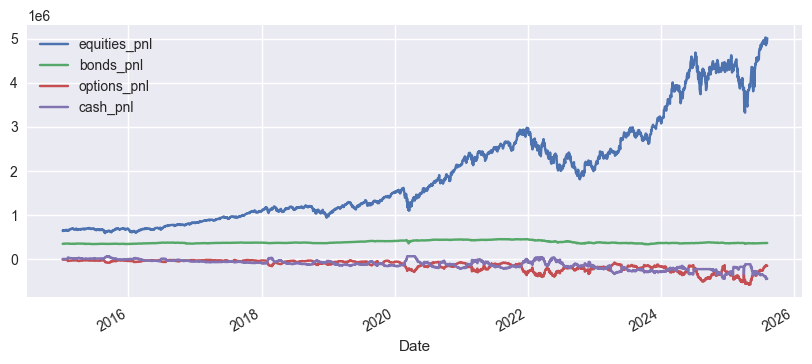

In [249]:
holdings_shares# daily component PnLs (level differences)
shares_pnl = shares_v.diff().fillna(shares_v.iloc[0])
# Per-instrument daily value
per_instr_v = holdings_shares.reindex(dates).multiply(prices.reindex(dates)).fillna(0.0)

# Split first 4 (equities) and last 4 (bonds)
equities_v = per_instr_v.iloc[:, :4].sum(axis=1)
bonds_v    = per_instr_v.iloc[:, 4:8].sum(axis=1)

# PnL from day to day
equities_pnl = equities_v.diff().fillna(equities_v.iloc[0])
bonds_pnl    = bonds_v.diff().fillna(bonds_v.iloc[0])
options_pnl  = options_v.diff().fillna(options_v.iloc[0])
cash_pnl     = cash_v.diff().fillna(cash_v.iloc[0])

components_pnl = pd.DataFrame({
    'equities_pnl': equities_pnl,
    'bonds_pnl': bonds_pnl,
    'options_pnl': options_pnl,
    'cash_pnl': cash_pnl
}, index=dates)
attrib_cum = components_pnl.cumsum()
attrib_cum[['equities_pnl', 'bonds_pnl', 'options_pnl', 'cash_pnl']].plot(figsize=(10,4))


[WARN] No NAV rows for GFC (2008-09-01 to 2009-03-09)

Recomputed stress_df:
         episode  return  max_drawdown  ann_vol
0            GFC     NaN           NaN      NaN
1          COVID -0.2636       -0.2717   0.7047
2  2022_drawdown -0.4071       -0.4071   0.3331


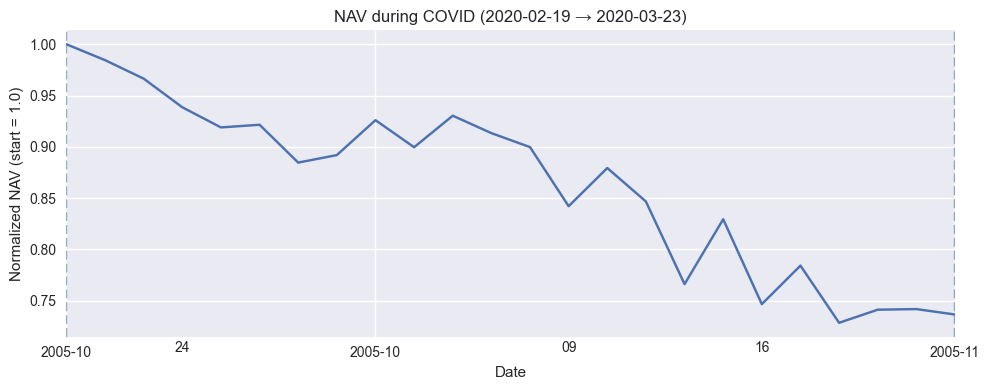

Saved data/phase5_stress_nav_COVID.png


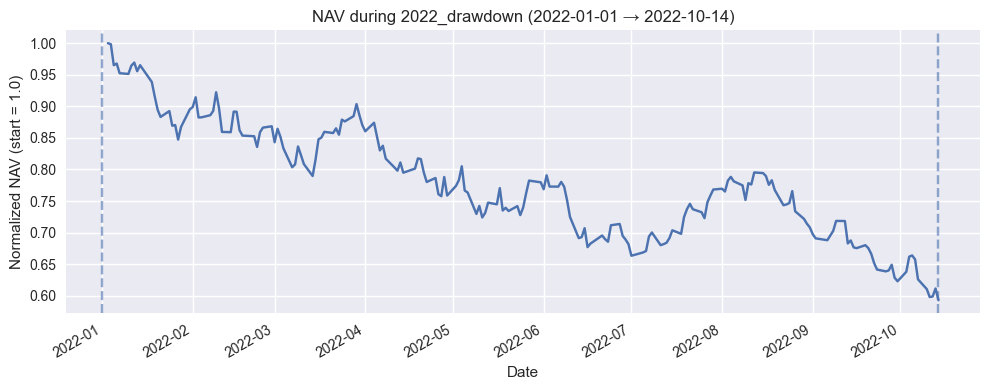

Saved data/phase5_stress_nav_2022_drawdown.png


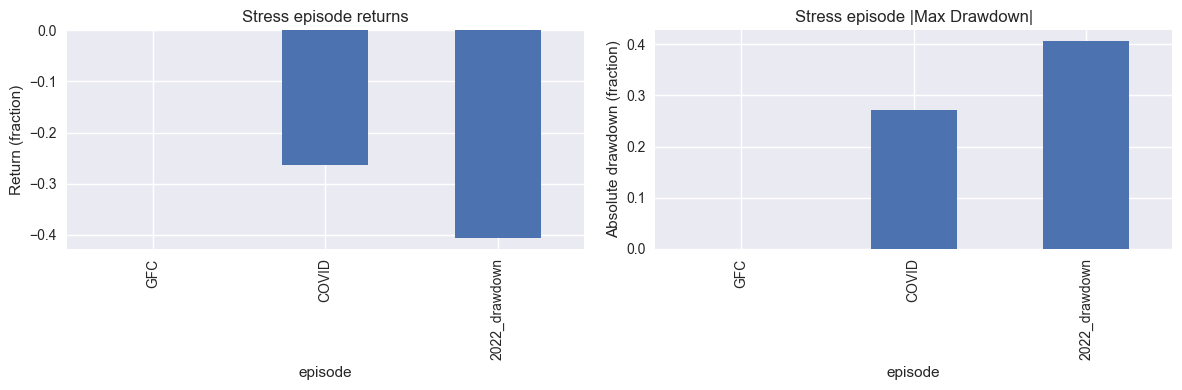

Saved data/phase5_stress_summary.png


In [260]:
# ---- Stress-episode plotting & summary (paste after Phase 5) ----
import matplotlib.dates as mdates

# Ensure NAV index is datetime
if not np.issubdtype(nav.index.dtype, np.datetime64):
    try:
        nav.index = pd.to_datetime(nav.index)
        print("Converted nav.index to datetime")
    except Exception as e:
        print("Failed to convert nav.index to datetime:", e)

# Repair max_drawdown early-return shape (optional but safer)
def max_drawdown_safe(series):
    roll_max = series.cummax()
    dd = series / roll_max - 1.0
    mdd = dd.min()
    if pd.isna(mdd):
        # return consistent 5-tuple as used elsewhere
        return np.nan, None, None, None, dd
    end = dd.idxmin()
    start = series.loc[:end].idxmax()
    length = (end - start).days
    return float(mdd), start, end, length, dd

# Recompute stress_df robustly (so we know exactly what we plot)
stress_results = []
for name, s, e in stress_list:
    s_ts = pd.to_datetime(s)
    e_ts = pd.to_datetime(e)
    mask = (nav.index >= s_ts) & (nav.index <= e_ts)
    sub_nav = nav.loc[mask]
    if sub_nav.empty:
        stress_results.append((name, np.nan, np.nan, np.nan))
        print(f"[WARN] No NAV rows for {name} ({s_ts.date()} to {e_ts.date()})")
    else:
        ret = sub_nav.iloc[-1] / sub_nav.iloc[0] - 1.0
        mdd_sub, _, _, _, _ = max_drawdown_safe(sub_nav)
        vol_sub = sub_nav.pct_change().dropna().std(ddof=0) * np.sqrt(TRADING_DAYS)
        stress_results.append((name, float(ret), float(mdd_sub), float(vol_sub)))
stress_df = pd.DataFrame(stress_results, columns=['episode','return','max_drawdown','ann_vol'])
stress_df.to_csv('data/phase5_stress_episodes_recomputed.csv', index=False)
print("\nRecomputed stress_df:")
print(stress_df)

# Create folder if missing
os.makedirs('data', exist_ok=True)

# 1) Per-episode NAV plots (normalized)
for idx, row in stress_df.iterrows():
    name = row['episode']
    s, e = [(x[1], x[2]) for x in stress_list if x[0] == name][0]
    s_ts = pd.to_datetime(s)
    e_ts = pd.to_datetime(e)
    mask = (nav.index >= s_ts) & (nav.index <= e_ts)
    sub = nav.loc[mask]
    if sub.empty:
        continue
    plt.figure(figsize=(10,4))
    (sub / sub.iloc[0]).plot()
    plt.title(f"NAV during {name} ({s_ts.date()} → {e_ts.date()})")
    plt.ylabel("Normalized NAV (start = 1.0)")
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.axvline(s_ts, linestyle='--', alpha=0.6)
    plt.axvline(e_ts, linestyle='--', alpha=0.6)
    plt.tight_layout()
    fname = f"data/phase5_stress_nav_{name}.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    print(f"Saved {fname}")

# 2) Stress summary bar charts (return & max drawdown)
if not stress_df[['return','max_drawdown']].dropna(how='all').empty:
    # drop episodes with all-NaN
    splot = stress_df.set_index('episode')[['return','max_drawdown']].fillna(0.0)
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    splot['return'].plot(kind='bar', ax=ax[0], title='Stress episode returns')
    ax[0].set_ylabel('Return (fraction)')
    splot['max_drawdown'].abs().plot(kind='bar', ax=ax[1], title='Stress episode |Max Drawdown|')
    ax[1].set_ylabel('Absolute drawdown (fraction)')
    plt.tight_layout()
    plt.savefig('data/phase5_stress_summary.png', dpi=150)
    plt.show()
    print("Saved data/phase5_stress_summary.png")
else:
    print("No non-NaN stress episodes to plot in summary chart.")


=== Phase 5 — Summary Metrics ===
Period: 2015-01-05 to 2025-08-08  (n=2665)
Annualized return: 15.9624%
Annualized vol:    24.6075%
Sharpe (ann):      0.723
Sortino:           0.836
Max Drawdown:      -41.3447%  (from 2021-11-19 00:00:00 to 2022-10-14 00:00:00, 329 days)
Calmar:            0.386
VaR95 hist (daily): 2.3441%, CVaR95 hist: 3.6724%
VaR99 hist (daily): 4.2827%, CVaR99 hist: 6.1865%
VaR95 param (daily): 2.4789%, CVaR95 param: 3.1267%
Beta vs SPY: 1.101, Corr: 0.804
Recon check (shares+options+cash == NAV): True


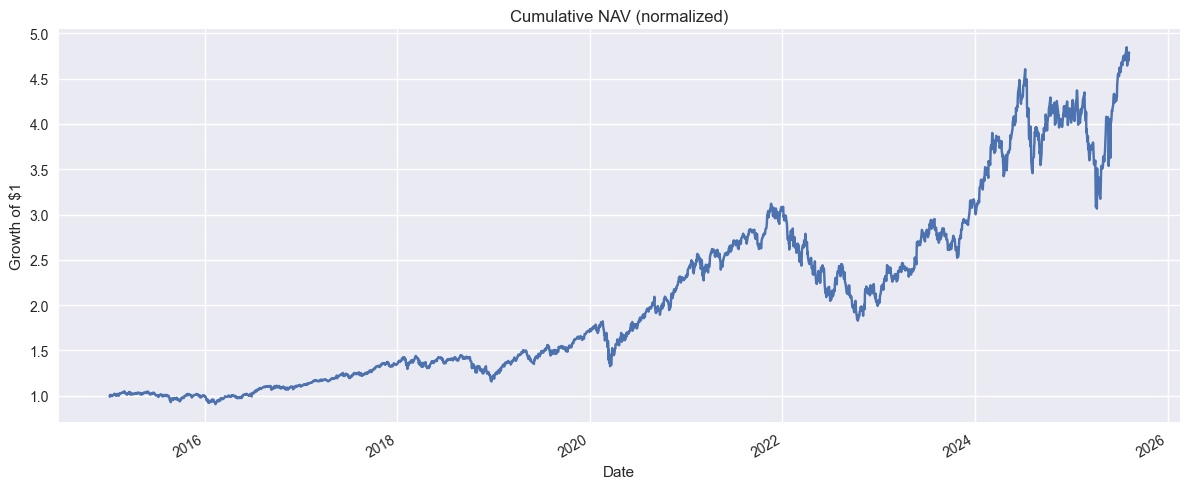

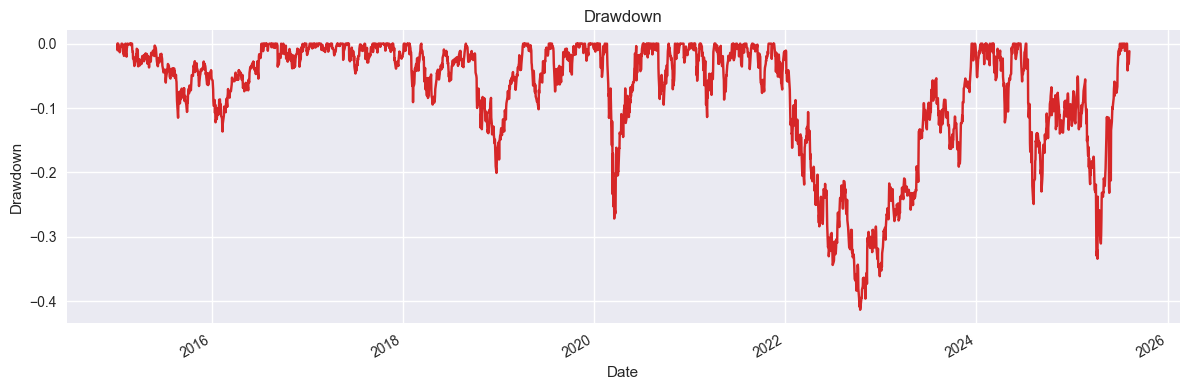

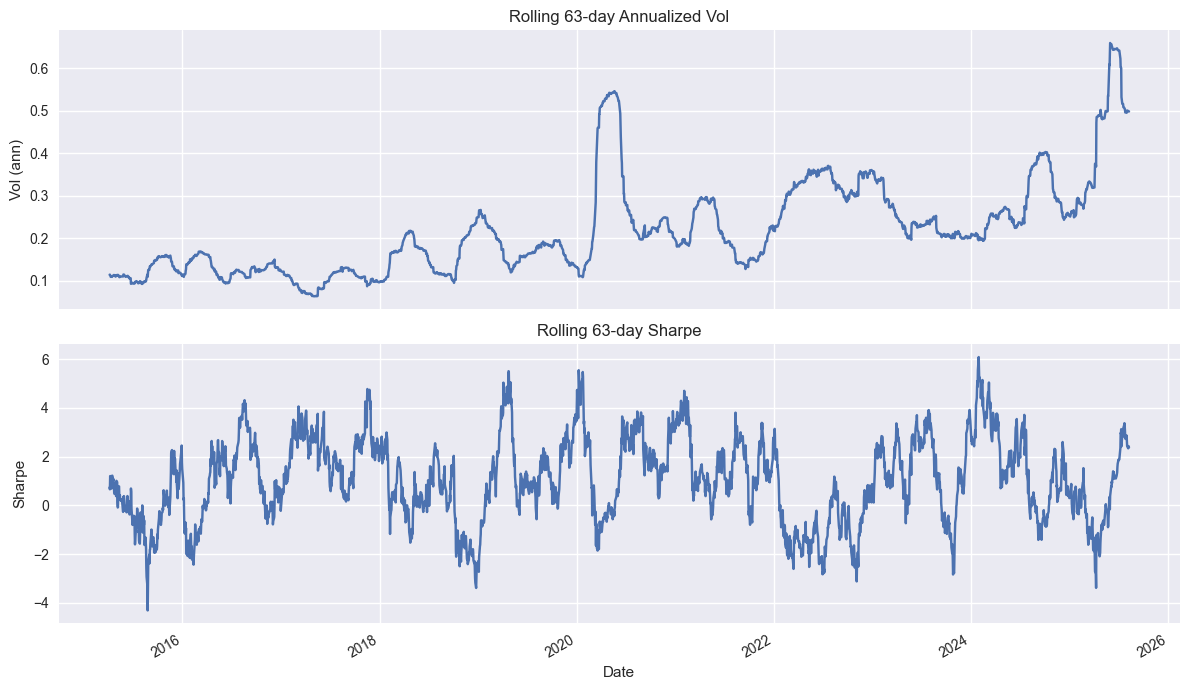

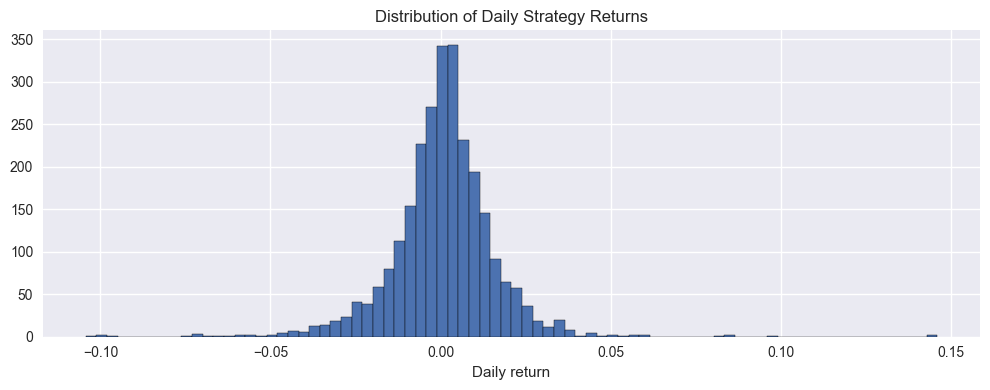

C:\Users\91983\AppData\Local\Temp\ipykernel_33808\3835831539.py:238: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.DataFrame({'opt1': opt1_pos.reindex(dates).fillna(method='ffill'),
C:\Users\91983\AppData\Local\Temp\ipykernel_33808\3835831539.py:239: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'opt2': opt2_pos.reindex(dates).fillna(method='ffill')}).plot()


<Figure size 1200x300 with 0 Axes>

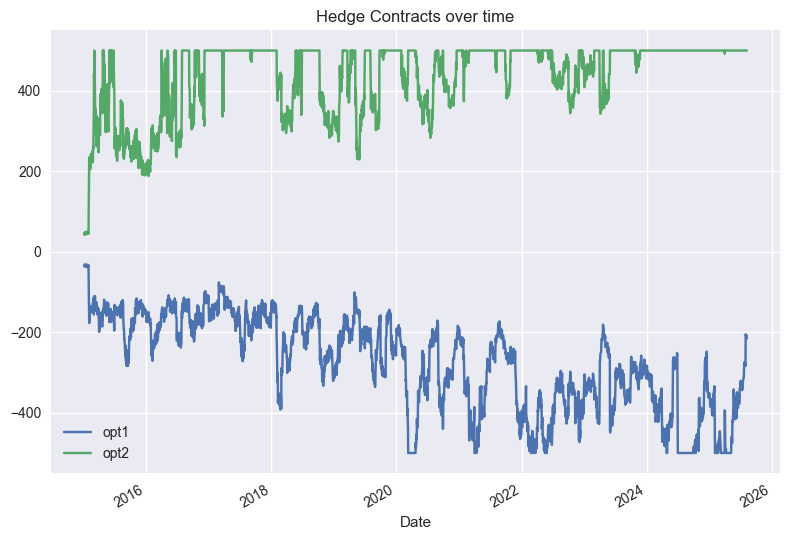

<Figure size 1000x400 with 0 Axes>

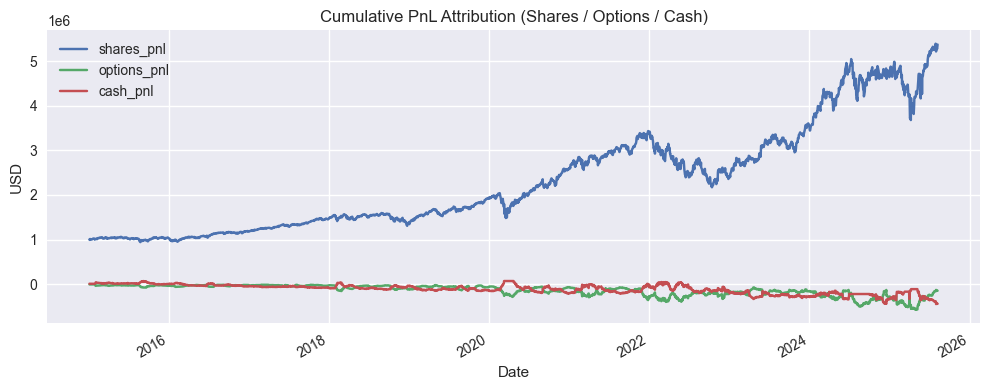


Saved standard phase 5 artifacts to ./data/

Generating historical stress episode NAV plots...
[WARN] No NAV rows for GFC (2008-09-01 → 2009-03-09) — skipping plot


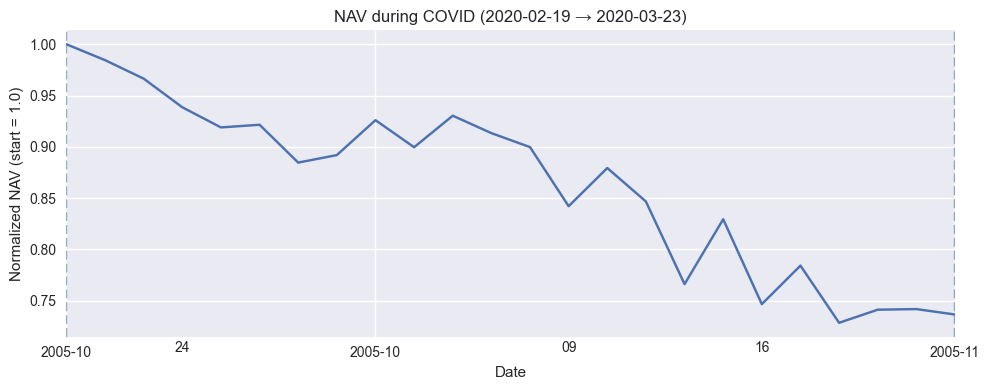

Saved data/phase5_stress_nav_COVID.png


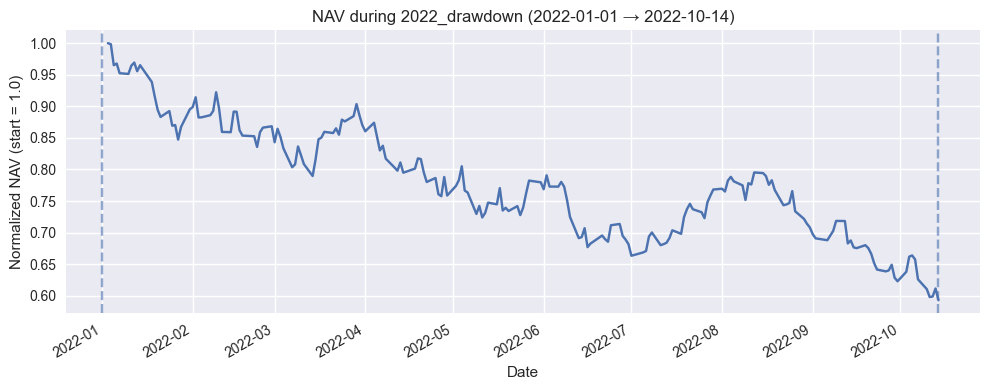

Saved data/phase5_stress_nav_2022_drawdown.png

--- Vasicek fitting & Monte Carlo stress test ---
[Vasicek fit] a=0.008783, b=46.614918%, sigma=0.467175%, phi=0.999965
[Vasicek] Estimated NAV sensitivity to 1-unit short-rate change (beta_rate): 1.106025
[Vasicek scenario] Terminal horizon VAR95: -1.5622%, CVaR95: -0.8329%


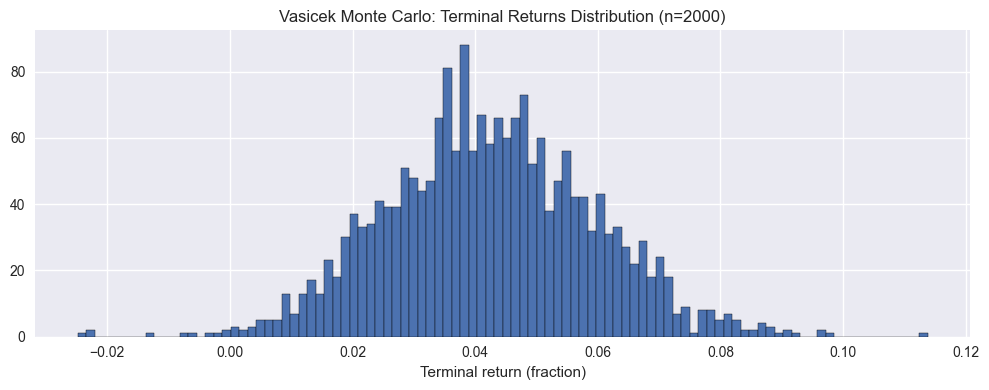

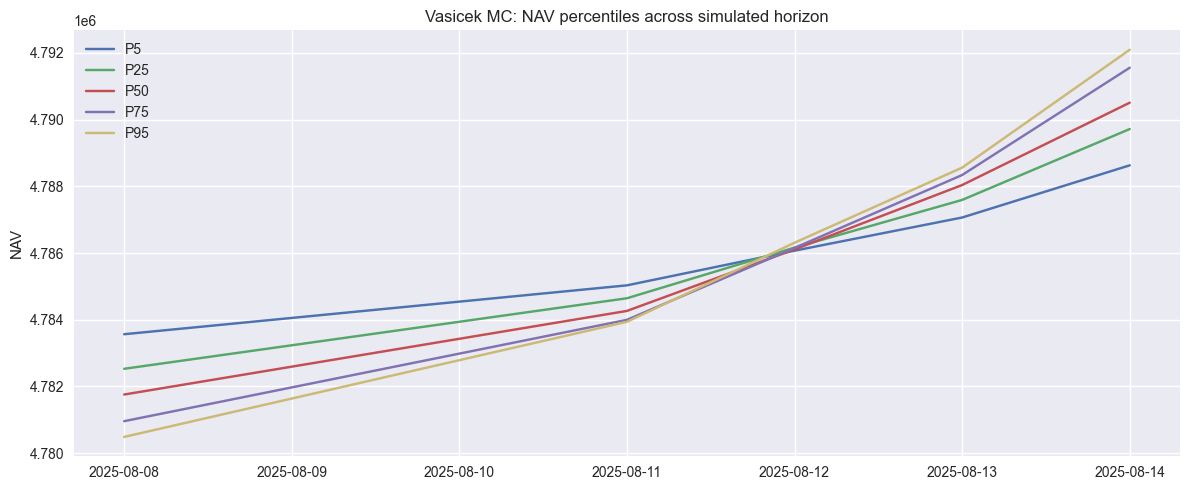

Saved Vasicek scenario artifacts to ./data/ (terminal hist, percentiles, summary)
Saved combined stress summary: data/phase5_combined_stress_summary.csv

--- Diagnostics ---
NAV period: 2015-01-05 to 2025-08-08 (2665 rows)
Short-rate series used for fit (sample):
DATE
2025-08-01   0.0435
2025-08-04   0.0435
2025-08-05   0.0434
2025-08-06   0.0432
2025-08-07   0.0432
Name: DGS3MO, dtype: float64
Vasicek fit -> a=0.008783, b=46.614918%, sigma=0.467175%, r0=4.320000%
Beta_rate used to map rate deltas -> returns: 1.106025
Simulated horizon (years): 10.590006844626968, steps: 2669, sims: 2000
Terminal NAV (sample): [4809442.4071 4860688.2317 4933890.0207 4986076.4177 5043032.3977
 5121453.1551 5182530.9363]

Phase 5 (w/ Vasicek scenarios) complete. Files in ./data/:
 - phase5_cumulative_nav.png
 - phase5_drawdown.png
 - phase5_rolling_metrics.png
 - phase5_return_hist.png
 - phase5_contracts.png
 - phase5_attribution_cumulative.png
 - phase5_results_snapshot.csv
 - phase5_daily_components_p

In [266]:
# -----------------------------
# Phase 5 — Backtesting, Risk Reporting, Vasicek Scenarios & Tear Sheet
# Paste/run this after your Phase 4 run
# -----------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import timedelta

plt.style.use("seaborn-v0_8")
os.makedirs('data', exist_ok=True)

# -----------------------------
# REQUIRED INPUTS (same as before)
# -----------------------------
required = ['results', 'prices', 'holdings_shares', 'opt1_pos', 'opt2_pos',
            'trade_costs', 'premium_flows', 'cash', 'hedge_underlying',
            'r_annual', 'contract_multiplier']
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(f"Missing required variables from Phase 4: {missing}")

# Local aliases
nav = results['mtm_portfolio'].copy()
mtm_hedge = results.get('mtm_hedge', pd.Series(0.0, index=nav.index))
dates = nav.index.sort_values()

# Strategy daily returns (handle zeros / NaNs)
strategy_ret = nav.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Benchmark returns (existing or from prices)
if 'benchmark_returns' in globals():
    benchmark_ret = benchmark_returns.reindex(dates).fillna(0.0)
else:
    if hedge_underlying not in prices.columns:
        raise RuntimeError(f"Benchmark not provided and {hedge_underlying} not found in prices.")
    benchmark_ret = prices[hedge_underlying].reindex(dates).pct_change().fillna(0.0)

# -----------------------------
# Helper metrics & fixed max_drawdown
# -----------------------------
TRADING_DAYS = 252

def ann_return(returns):
    returns = returns.dropna()
    if returns.empty:
        return np.nan
    cum = (1 + returns).prod()
    n = returns.shape[0]
    return cum ** (TRADING_DAYS / n) - 1

def ann_vol(returns):
    return returns.std(ddof=0) * np.sqrt(TRADING_DAYS)

def sharpe(returns, rf_annual=0.0):
    if returns.empty:
        return np.nan
    rf_daily = (1 + rf_annual) ** (1 / TRADING_DAYS) - 1
    ex = returns - rf_daily
    vol = returns.std(ddof=0)
    return np.nan if vol == 0 else ex.mean() / vol * np.sqrt(TRADING_DAYS)

def sortino(returns, rf_annual=0.0):
    returns = returns.dropna()
    rf_ann = rf_annual
    downside = returns[returns < 0]
    if downside.empty:
        return np.nan
    downside_std = downside.std(ddof=0) * np.sqrt(TRADING_DAYS)
    return (ann_return(returns) - rf_ann) / downside_std if downside_std != 0 else np.nan

def max_drawdown(series):
    # returns: mdd (float), start (ts), end (ts), length_days (int), dd_series (Series)
    roll_max = series.cummax()
    dd = series / roll_max - 1.0
    mdd = dd.min()
    if pd.isna(mdd):
        return np.nan, None, None, None, dd
    end = dd.idxmin()
    start = series.loc[:end].idxmax()
    length = (end - start).days
    return float(mdd), start, end, length, dd

def var_cvar(returns, alpha=0.95, method='historical'):
    r = returns.dropna()
    if r.empty:
        return np.nan, np.nan
    if method == 'historical':
        var = -np.quantile(r, 1 - alpha)
        cvar = -r[r <= np.quantile(r, 1 - alpha)].mean()
        return float(var), float(cvar)
    else:
        mu = r.mean()
        sigma = r.std(ddof=0)
        if sigma == 0:
            return np.nan, np.nan
        z = norm.ppf(alpha)
        var = -(mu - z * sigma)
        cvar = -(mu - sigma * (norm.pdf(z) / (1 - alpha)))
        return float(var), float(cvar)

# -----------------------------
# Attribution (Shares / Options / Cash)
# -----------------------------
shares_v = (holdings_shares.reindex(dates).multiply(prices.reindex(dates))).sum(axis=1).fillna(0.0)
options_v = mtm_hedge.reindex(dates).fillna(0.0)
cash_v = cash.reindex(dates).fillna(0.0)

recon_ok = np.allclose((shares_v + options_v + cash_v).values, nav.fillna(0).values, atol=1e-6)

shares_pnl = shares_v.diff().fillna(shares_v.iloc[0])
options_pnl = options_v.diff().fillna(options_v.iloc[0])
cash_pnl = cash_v.diff().fillna(cash_v.iloc[0])

components_pnl = pd.DataFrame({
    'shares_pnl': shares_pnl,
    'options_pnl': options_pnl,
    'cash_pnl': cash_pnl
}, index=dates)
components_pnl['total_components'] = components_pnl.sum(axis=1)
reported_pnl = results['pnl'].reindex(dates).fillna(0.0)

# -----------------------------
# Point-in-time summary metrics
# -----------------------------
ann_ret = ann_return(strategy_ret)
annstd = ann_vol(strategy_ret)
sr = sharpe(strategy_ret, rf_annual=r_annual)
sort = sortino(strategy_ret, rf_annual=r_annual)
mdd, mdd_s, mdd_e, mdd_len, dd_series = max_drawdown(nav)
calmar = ann_ret / abs(mdd) if (not pd.isna(ann_ret) and not pd.isna(mdd) and mdd < 0) else np.nan

VaR95_h, CVaR95_h = var_cvar(strategy_ret, alpha=0.95, method='historical')
VaR99_h, CVaR99_h = var_cvar(strategy_ret, alpha=0.99, method='historical')
VaR95_p, CVaR95_p = var_cvar(strategy_ret, alpha=0.95, method='parametric')
VaR99_p, CVaR99_p = var_cvar(strategy_ret, alpha=0.99, method='parametric')

# Rolling metrics
rolling_vol_63 = strategy_ret.rolling(window=63).std(ddof=0) * np.sqrt(TRADING_DAYS)
rolling_sharpe_63 = (strategy_ret.rolling(63).mean() / strategy_ret.rolling(63).std(ddof=0)) * np.sqrt(TRADING_DAYS)

# Beta vs benchmark
cov = np.cov(strategy_ret.fillna(0.0), benchmark_ret.fillna(0.0))
bench_var = np.var(benchmark_ret.fillna(0.0))
beta_vs_bench = cov[0,1] / bench_var if bench_var != 0 else np.nan
corr_vs_bench = strategy_ret.corr(benchmark_ret)

# Stress episodes to evaluate (common windows)
stress_list = [
    ("GFC", "2008-09-01", "2009-03-09"),
    ("COVID", "2020-02-19", "2020-03-23"),
    ("2022_drawdown", "2022-01-01", "2022-10-14"),
]
stress_results = []
for name, s, e in stress_list:
    try:
        s_ts = pd.to_datetime(s)
        e_ts = pd.to_datetime(e)
        sub_nav = nav.loc[(nav.index >= s_ts) & (nav.index <= e_ts)]
        if sub_nav.empty:
            stress_results.append((name, np.nan, np.nan, np.nan))
        else:
            ret = sub_nav.iloc[-1] / sub_nav.iloc[0] - 1.0
            mdd_sub, _, _, _, _ = max_drawdown(sub_nav)
            vol_sub = sub_nav.pct_change().dropna().std(ddof=0) * np.sqrt(TRADING_DAYS)
            stress_results.append((name, float(ret), float(mdd_sub), float(vol_sub)))
    except Exception:
        stress_results.append((name, np.nan, np.nan, np.nan))
stress_df = pd.DataFrame(stress_results, columns=['episode','return','max_drawdown','ann_vol'])

# -----------------------------
# Output / Prints (summary)
# -----------------------------
print("=== Phase 5 — Summary Metrics ===")
print(f"Period: {dates[0].date()} to {dates[-1].date()}  (n={len(dates)})")
print(f"Annualized return: {ann_ret:.4%}")
print(f"Annualized vol:    {annstd:.4%}")
print(f"Sharpe (ann):      {sr:.3f}")
print(f"Sortino:           {sort:.3f}")
if not pd.isna(mdd):
    print(f"Max Drawdown:      {mdd:.4%}  (from {mdd_s} to {mdd_e}, {mdd_len} days)")
else:
    print("Max Drawdown:      n/a")
print(f"Calmar:            {calmar:.3f}")
print(f"VaR95 hist (daily): {VaR95_h:.4%}, CVaR95 hist: {CVaR95_h:.4%}")
print(f"VaR99 hist (daily): {VaR99_h:.4%}, CVaR99 hist: {CVaR99_h:.4%}")
print(f"VaR95 param (daily): {VaR95_p:.4%}, CVaR95 param: {CVaR95_p:.4%}")
print(f"Beta vs {hedge_underlying}: {beta_vs_bench:.3f}, Corr: {corr_vs_bench:.3f}")
print(f"Recon check (shares+options+cash == NAV): {recon_ok}")

# -----------------------------
# Plots – Tear sheet style (existing)
# -----------------------------
# 1) Cumulative NAV
plt.figure(figsize=(12,5))
(nav / nav.iloc[0]).plot()
plt.title("Cumulative NAV (normalized)")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.tight_layout()
plt.savefig('data/phase5_cumulative_nav.png', dpi=150)
plt.show()

# 2) Drawdown
plt.figure(figsize=(12,4))
dd_series.plot(color='tab:red')
plt.title("Drawdown")
plt.ylabel("Drawdown")
plt.grid(True)
plt.tight_layout()
plt.savefig('data/phase5_drawdown.png', dpi=150)
plt.show()

# 3) Rolling vol & rolling sharpe
fig, ax = plt.subplots(2,1, figsize=(12,7), sharex=True)
rolling_vol_63.plot(ax=ax[0], title='Rolling 63-day Annualized Vol')
ax[0].set_ylabel('Vol (ann)')
rolling_sharpe_63.plot(ax=ax[1], title='Rolling 63-day Sharpe')
ax[1].set_ylabel('Sharpe')
plt.tight_layout()
plt.savefig('data/phase5_rolling_metrics.png', dpi=150)
plt.show()

# 4) Return distribution
plt.figure(figsize=(10,4))
strategy_ret.hist(bins=80, edgecolor='black')
plt.title("Distribution of Daily Strategy Returns")
plt.xlabel("Daily return")
plt.tight_layout()
plt.savefig('data/phase5_return_hist.png', dpi=150)
plt.show()

# 5) Contracts over time
if 'opt1_pos' in globals() and 'opt2_pos' in globals():
    plt.figure(figsize=(12,3))
    pd.DataFrame({'opt1': opt1_pos.reindex(dates).fillna(method='ffill'),
                  'opt2': opt2_pos.reindex(dates).fillna(method='ffill')}).plot()
    plt.title("Hedge Contracts over time")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('data/phase5_contracts.png', dpi=150)
    plt.show()

# 6) Attribution (cumulative)
attrib_cum = components_pnl.cumsum()
plt.figure(figsize=(10,4))
attrib_cum[['shares_pnl', 'options_pnl', 'cash_pnl']].plot(figsize=(10,4))
plt.title("Cumulative PnL Attribution (Shares / Options / Cash)")
plt.ylabel("USD")
plt.tight_layout()
plt.savefig('data/phase5_attribution_cumulative.png', dpi=150)
plt.show()

# Save CSVs (initial)
results.to_csv('data/phase5_results_snapshot.csv')
components_pnl.to_csv('data/phase5_daily_components_pnl.csv')
stress_df.to_csv('data/phase5_stress_episodes.csv', index=False)

summary_df = pd.DataFrame({
    'metric': [
        'ann_return','ann_vol','sharpe','sortino','max_drawdown','mdd_start','mdd_end','mdd_length_days',
        'calmar','var95_hist','cvar95_hist','beta','corr','recon_ok'
    ],
    'value': [
        ann_ret, annstd, sr, sort, mdd, mdd_s, mdd_e, mdd_len,
        calmar, VaR95_h, CVaR95_h, beta_vs_bench, corr_vs_bench, recon_ok
    ]
})
summary_df.to_csv('data/phase5_summary_metrics.csv', index=False)

print("\nSaved standard phase 5 artifacts to ./data/")

# -----------------------------
# Historical stress episode plots
# -----------------------------
import matplotlib.dates as mdates

print("\nGenerating historical stress episode NAV plots...")
for name, s, e in stress_list:
    s_ts = pd.to_datetime(s)
    e_ts = pd.to_datetime(e)
    mask = (nav.index >= s_ts) & (nav.index <= e_ts)
    sub = nav.loc[mask]
    if sub.empty:
        print(f"[WARN] No NAV rows for {name} ({s_ts.date()} → {e_ts.date()}) — skipping plot")
        continue
    plt.figure(figsize=(10,4))
    (sub / sub.iloc[0]).plot()
    plt.title(f"NAV during {name} ({s_ts.date()} → {e_ts.date()})")
    plt.ylabel("Normalized NAV (start = 1.0)")
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.axvline(s_ts, linestyle='--', alpha=0.6)
    plt.axvline(e_ts, linestyle='--', alpha=0.6)
    plt.tight_layout()
    fname = f"data/phase5_stress_nav_{name}.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    print(f"Saved {fname}")

# -----------------------------
# Vasicek: fit from history, simulate, scenario NAVs, and stress outputs
# -----------------------------
print("\n--- Vasicek fitting & Monte Carlo stress test ---")

def fit_vasicek(short_rates, dt=1/252):
    """
    Fit Vasicek parameters from short-rate time series using AR(1) mapping:
      r_{t+1} = phi * r_t + c + eps
    phi = exp(-a dt) -> a = -ln(phi)/dt
    c = b * (1 - phi) -> b = c / (1 - phi)
    Residual variance -> sigma via discrete variance mapping.
    Returns (a, b, sigma, phi, c)
    """
    sr = np.asarray(short_rates).astype(float)
    sr = sr[~np.isnan(sr)]
    if len(sr) < 50:
        # small sample fallback
        raise ValueError("Not enough short-rate history to fit Vasicek (need >=50 non-NaN).")
    r_t = sr[:-1]
    r_t1 = sr[1:]

    # OLS phi, c
    X = np.vstack([r_t, np.ones_like(r_t)]).T
    coef, _, _, _ = np.linalg.lstsq(X, r_t1, rcond=None)
    phi = coef[0]
    c = coef[1]

    # numerical safety
    if phi <= 0 or phi >= 1:
        # clamp to small epsilon to ensure a finite a
        phi = np.clip(phi, 1e-6, 0.999999)

    a = -np.log(phi) / dt
    b = c / (1 - phi)

    residuals = r_t1 - (phi * r_t + c)
    var_eps = np.var(residuals, ddof=1)
    # discrete variance -> sigma
    denom = (1 - np.exp(-2 * a * dt)) / (2 * a)
    if denom <= 0:
        sigma_hat = np.sqrt(max(var_eps, 0.0))
    else:
        sigma_hat = np.sqrt(max(var_eps / denom, 0.0))

    return float(a), float(b), float(sigma_hat), float(phi), float(c)

def vasicek_simulate(a, b, sigma, r0, T, dt=1/252, n_sims=2000, seed=None):
    """
    Exact discrete-time OU/Vasicek simulation (vectorized).
    Returns rates array shape (n_steps+1, n_sims) and time index length n_steps+1.
    """
    if seed is not None:
        np.random.seed(seed)
    n_steps = int(np.ceil(T / dt))
    phi = np.exp(-a * dt)
    mu = b * (1 - phi)
    sd = sigma * np.sqrt((1 - np.exp(-2 * a * dt)) / (2 * a)) if a > 0 else sigma * np.sqrt(dt)
    rates = np.zeros((n_steps + 1, n_sims))
    rates[0, :] = r0
    for t in range(1, n_steps + 1):
        eps = np.random.randn(n_sims)
        rates[t, :] = phi * rates[t-1, :] + mu + sd * eps
    return rates, n_steps

# 1) Find short-rate history in environment or fallback to r_annual
short_rate_candidates = ['short_rate', 'short_rates', 'short_rate_series', 'short_rate_history', 'short_rate_hist', 'r_short']
short_series = None
for key in short_rate_candidates:
    if key in globals():
        obj = globals()[key]
        if isinstance(obj, pd.Series):
            short_series = obj.dropna()
            break
        elif isinstance(obj, (np.ndarray, list)):
            short_series = pd.Series(obj)
            break
        elif isinstance(obj, pd.DataFrame):
            # if df, try first numeric column
            try:
                col = obj.select_dtypes(include=[np.number]).columns[0]
                short_series = obj[col].dropna()
                break
            except Exception:
                continue

if short_series is None:
    # try to see if a file exists
    if os.path.exists('short_rate_history.csv'):
        try:
            tmp = pd.read_csv('short_rate_history.csv', parse_dates=True, index_col=0)
            col = tmp.select_dtypes(include=[np.number]).columns[0]
            short_series = tmp[col].dropna()
            print("[INFO] Loaded short_rate_history.csv for Vasicek fit.")
        except Exception as e:
            print("[WARN] Could not read short_rate_history.csv:", e)

if short_series is None:
    # fallback: create a constant short-rate series using r_annual
    print("[WARN] No short-rate history found in globals or file. Falling back to constant short rate using r_annual.")
    short_series = pd.Series(r_annual, index=dates).astype(float)

# If short_series has a datetime index not aligned with nav, reindex to nav dates using forward-fill/backfill
if not np.issubdtype(short_series.index.dtype, np.datetime64):
    try:
        # if it's just values, create index with nav dates tail
        short_series = pd.Series(short_series.values, index=dates[:len(short_series)])
    except Exception:
        pass

# align short series to NAV dates for sensitivity/regression; but for fitting we will use the raw series (if it is longer)
short_series_for_fit = short_series.copy()
# drop NaNs for fit
short_series_for_fit = short_series_for_fit.dropna()
if len(short_series_for_fit) < 50:
    # attempt to align to prices index (wider) if available
    combined_index = prices.index.union(dates).sort_values()
    try:
        short_series_for_fit = short_series.reindex(combined_index).ffill().bfill().dropna()
    except Exception:
        pass

# final guard
if len(short_series_for_fit) < 50:
    print("[WARN] Short-rate history is short (<50 samples). Vasicek fit may be noisy.")

# Fit Vasicek (try/except)
try:
    dt = 1 / TRADING_DAYS
    a_fit, b_fit, sigma_fit, phi_fit, c_fit = fit_vasicek(short_series_for_fit.values, dt=dt)
    print(f"[Vasicek fit] a={a_fit:.6f}, b={b_fit:.6%}, sigma={sigma_fit:.6%}, phi={phi_fit:.6f}")
except Exception as e:
    print("[ERROR] Vasicek fit failed:", e)
    # fallback: simple param guesses
    a_fit, b_fit, sigma_fit = 0.15, float(short_series_for_fit.mean()) if len(short_series_for_fit)>0 else r_annual, 0.01
    phi_fit, c_fit = np.exp(-a_fit*dt), b_fit*(1-np.exp(-a_fit*dt))
    print(f"[Vasicek fallback] a={a_fit:.6f}, b={b_fit:.6%}, sigma={sigma_fit:.6%}")

# 2) Simulation parameters (can override by setting vars in env)
vasicek_n_sims = globals().get('vasicek_n_sims', 2000)
vasicek_T = globals().get('vasicek_T', max(1.0, (dates[-1] - dates[0]).days / 365.25))  # default 1 year or span
vasicek_seed = globals().get('vasicek_seed', 42)

# initial short rate r0: use last observed short rate aligned to nav if possible
if dates[-1] in short_series.index:
    r0 = float(short_series.reindex(dates).loc[dates[-1]])
else:
    r0 = float(short_series_for_fit.iloc[-1]) if len(short_series_for_fit)>0 else r_annual

# simulate
rates_sim, n_steps = vasicek_simulate(a_fit, b_fit, sigma_fit, r0, T=vasicek_T, dt=dt, n_sims=vasicek_n_sims, seed=vasicek_seed)
time_index_sim = pd.date_range(start=dates[-1], periods=n_steps+1, freq=pd.offsets.BDay())  # business-day like index

# Build short-rate scenario DataFrame (optional: save a sample)
sample_idx = min(50, vasicek_n_sims)
pd.DataFrame(rates_sim[:, :sample_idx], index=time_index_sim).iloc[:min(250, len(time_index_sim)), :].to_csv('data/vasicek_sample_paths.csv')

# 3) Derive NAV sensitivity to short-rate changes (pragmatic proxy)
# Align short_series to strategy_ret index (daily)
aligned_short = short_series.reindex(strategy_ret.index).ffill().bfill()
rate_diff = aligned_short.diff().fillna(0.0)
# Use covariance-based sensitivity: beta_rate = cov(strategy_ret, rate_diff) / var(rate_diff)
valid_mask = (~strategy_ret.isna()) & (~rate_diff.isna())
if valid_mask.sum() < 10 or rate_diff.var() == 0:
    print("[WARN] Not enough overlap between NAV returns and short-rate history to estimate sensitivity. Sensitivity set to 0.")
    beta_rate = 0.0
else:
    covmat = np.cov(strategy_ret[valid_mask].values, rate_diff[valid_mask].values)
    beta_rate = covmat[0,1] / (np.var(rate_diff[valid_mask].values) if np.var(rate_diff[valid_mask].values) != 0 else np.nan)
    if np.isnan(beta_rate):
        beta_rate = 0.0
print(f"[Vasicek] Estimated NAV sensitivity to 1-unit short-rate change (beta_rate): {beta_rate:.6f}")

# 4) Build scenario NAV paths using simulated short-rate changes and beta_rate
# We produce simulated daily rate changes (delta r) and map to simulated daily returns = beta_rate * delta_r
sim_delta_r = np.diff(rates_sim, axis=0)  # shape (n_steps, n_sims)
# Map to returns:
sim_returns = beta_rate * sim_delta_r  # approximate daily returns from rate changes

# Convert to scenario NAV paths starting from current NAV point
nav_t0 = float(nav.iloc[-1])
sim_nav_paths = np.empty_like(sim_returns)
sim_nav_paths[0,:] = nav_t0 * (1 + sim_returns[0,:])
for t in range(1, sim_returns.shape[0]):
    sim_nav_paths[t,:] = sim_nav_paths[t-1,:] * (1 + sim_returns[t,:])

# terminal results at horizon
terminal_nav = sim_nav_paths[-1,:]
terminal_returns = (terminal_nav / nav_t0) - 1.0

# 5) Compute scenario-based VaR/CVaR (Vasicek-driven)
def tail_var(arr, alpha=0.95):
    arr = np.asarray(arr)
    if arr.size == 0:
        return np.nan, np.nan
    var = -np.quantile(arr, 1 - alpha)
    cvar = -arr[arr <= np.quantile(arr, 1 - alpha)].mean()
    return float(var), float(cvar)

Vas_kvs = {}
Vas_kvs['var95_sim_terminal'], Vas_kvs['cvar95_sim_terminal'] = tail_var(terminal_returns, 0.95)
Vas_kvs['var99_sim_terminal'], Vas_kvs['cvar99_sim_terminal'] = tail_var(terminal_returns, 0.99)
print(f"[Vasicek scenario] Terminal horizon VAR95: {Vas_kvs['var95_sim_terminal']:.4%}, CVaR95: {Vas_kvs['cvar95_sim_terminal']:.4%}")

# 6) Save Vasicek scenario artifacts & plots
# Histogram of terminal returns
plt.figure(figsize=(10,4))
plt.hist(terminal_returns, bins=100, edgecolor='black')
plt.title(f"Vasicek Monte Carlo: Terminal Returns Distribution (n={vasicek_n_sims})")
plt.xlabel("Terminal return (fraction)")
plt.tight_layout()
plt.savefig('data/phase5_vasicek_terminal_hist.png', dpi=150)
plt.show()

# Percentile paths (5th,25th,50th,75th,95th) across time
percentiles = [5,25,50,75,95]
pct_paths = np.percentile(sim_nav_paths, q=percentiles, axis=1)  # shape (len(percentiles), n_steps)
plt.figure(figsize=(12,5))
for i, q in enumerate(percentiles):
    plt.plot(time_index_sim[:pct_paths.shape[0]], pct_paths[:,i], label=f"P{q}")
plt.title("Vasicek MC: NAV percentiles across simulated horizon")
plt.ylabel("NAV")
plt.legend()
plt.tight_layout()
plt.savefig('data/phase5_vasicek_nav_percentiles.png', dpi=150)
plt.show()

# Save summary CSV for Vasicek scenarios
vas_summary = {
    'a_fit': a_fit, 'b_fit': b_fit, 'sigma_fit': sigma_fit, 'r0': r0,
    'beta_rate': beta_rate,
    'terminal_var95': Vas_kvs['var95_sim_terminal'],
    'terminal_cvar95': Vas_kvs['cvar95_sim_terminal'],
    'terminal_var99': Vas_kvs['var99_sim_terminal'],
    'terminal_cvar99': Vas_kvs['cvar99_sim_terminal'],
    'n_sims': vasicek_n_sims,
    'horizon_years': vasicek_T
}
vas_summary_df = pd.DataFrame(list(vas_summary.items()), columns=['metric','value'])
vas_summary_df.to_csv('data/phase5_vasicek_summary.csv', index=False)
print("Saved Vasicek scenario artifacts to ./data/ (terminal hist, percentiles, summary)")

# 7) Combine historical stress episodes and Vasicek outputs into a single stress table for reporting
combined = stress_df.copy()
combined = combined.set_index('episode')
# add Vasicek simulated worst percentiles as synthetic episodes
combined.loc['Vasicek_sim_5pct_tail'] = [np.nan, -Vas_kvs['var95_sim_terminal'], np.nan]  # put return ~ -VaR95
combined.loc['Vasicek_sim_1pct_tail'] = [np.nan, -Vas_kvs['var99_sim_terminal'], np.nan]
combined.to_csv('data/phase5_combined_stress_summary.csv')
print("Saved combined stress summary: data/phase5_combined_stress_summary.csv")

# 8) Extra diagnostics (optional prints)
print("\n--- Diagnostics ---")
print("NAV period:", dates[0].date(), "to", dates[-1].date(), f"({len(dates)} rows)")
print("Short-rate series used for fit (sample):")
try:
    print(short_series_for_fit.tail(5))
except Exception:
    print("n/a")
print(f"Vasicek fit -> a={a_fit:.6f}, b={b_fit:.6%}, sigma={sigma_fit:.6%}, r0={r0:.6%}")
print(f"Beta_rate used to map rate deltas -> returns: {beta_rate:.6f}")
print(f"Simulated horizon (years): {vasicek_T}, steps: {n_steps}, sims: {vasicek_n_sims}")
print("Terminal NAV (sample):", np.round(np.percentile(terminal_nav, [1,5,25,50,75,95,99]), 4))

# 9) Save key arrays for debugging (numpy)
np.save('data/vasicek_terminal_nav.npy', terminal_nav)
np.save('data/vasicek_sim_returns.npy', sim_returns)

print("\nPhase 5 (w/ Vasicek scenarios) complete. Files in ./data/:")
for fname in [
    'phase5_cumulative_nav.png','phase5_drawdown.png','phase5_rolling_metrics.png','phase5_return_hist.png',
    'phase5_contracts.png','phase5_attribution_cumulative.png','phase5_results_snapshot.csv',
    'phase5_daily_components_pnl.csv','phase5_stress_episodes.csv','phase5_summary_metrics.csv',
    'phase5_stress_nav_GFC.png','phase5_stress_nav_COVID.png','phase5_stress_nav_2022_drawdown.png',
    'phase5_vasicek_terminal_hist.png','phase5_vasicek_nav_percentiles.png','phase5_vasicek_summary.csv',
    'phase5_combined_stress_summary.csv','vasicek_sample_paths.csv'
]:
    if os.path.exists(os.path.join('data', fname)):
        print(" -", fname)

# End of Phase 5


In [265]:
pct_paths.shape

(5, 2669)